In [72]:
!pip install beautifulsoup4
!pip install requests
!pip install pandas
!pip install tqdm
!pip install scikit-learn
!pip install matplotlib
!pip install seaborn
!pip install urllib3

In [73]:
# 요약보기
pd.set_option('display.max_rows', 100)

In [132]:
#전체행 보기 
pd.set_option('display.max_rows', None)

In [197]:
%matplotlib inline
plt.rcParams['font.family'] = 'AppleGothic' # macOS 사용자
plt.rcParams['axes.unicode_minus'] = False

In [75]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import re
from datetime import datetime, timedelta
import zipfile
import io
import xml.etree.ElementTree as ET
from concurrent.futures import ThreadPoolExecutor, as_completed
from datetime import datetime, timedelta
import pandas as pd
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.contrib.concurrent import thread_map

# 수익률 상위 기준 투자 전략 수립

## 1. 후보군 선정
### 1) 선정기준
- 전체 상장 종목(코스피 + 코스닥) 중 수익률(24년 1월 ~ 24년 12월) 상위 00% 추출
- 중소형주 중 최근 1년 수익률 상위 100개 추출

### 2) 수익률(24년 1월 ~ 24년 12월) 상위 00% 추출
#### - 한국거래소 API에서 시가 총액 기준으로 크롤링

In [5]:
def get_stock_info(basDd):
  url = {
  "kospi_url": "http://data-dbg.krx.co.kr/svc/apis/sto/stk_bydd_trd",
  "kosdaq_url": "http://data-dbg.krx.co.kr/svc/apis/sto/ksq_bydd_trd"
  }

  params = {
    "basDd": basDd.strftime("%Y%m%d")
  }

  headers = {
    "AUTH_KEY": "18CEC6172A764513B4C60CAA3E3186D3AE2453C3"
  }
  market_is_open = requests.get(list(url.values())[0], params=params, headers=headers)
  if (market_is_open.json()['OutBlock_1'] == []):
    # print("Market is closed")
    return None
  # while (market_is_open.json()['OutBlock_1'] == []):
  #   print("Market is closed")
  #   basDd = basDd + timedelta(days=1)
  #   params['basDd'] = basDd.strftime("%Y%m%d")
  #   market_is_open = requests.get(list(url.values())[0], params=params, headers=headers)

  all_stock_info = pd.DataFrame()
    
  for url in url.values():
    response = requests.get(url, params=params, headers=headers)
    if response.status_code == 200:
      data = response.json()
      if 'OutBlock_1' in data:
          krx_stock_info = pd.DataFrame(data['OutBlock_1'])

          # 컬럼명 한글로 변환
          column_map = {
              'BAS_DD': '기준일자',
              'ISU_CD': '종목코드',
              'ISU_NM': '종목명',
              'MKT_NM': '시장구분',
              'SECT_TP_NM': '소속부',
              'TDD_CLSPRC': '종가',
              'CMPPREVDD_PRC': '대비',
              'FLUC_RT': '등락률',
              'TDD_OPNPRC': '시가',
              'TDD_HGPRC': '고가',
              'TDD_LWPRC': '저가',
              'ACC_TRDVOL': '거래량',
              'ACC_TRDVAL': '거래대금',
              'MKTCAP': '시가총액',
              'LIST_SHRS': '상장주식수'
          }

          krx_stock_info = krx_stock_info.rename(columns=column_map)

          numeric_columns = ['종가', '대비', '등락률', '시가', '고가', '저가', '거래량', '거래대금', '시가총액', '상장주식수']
          
          for col in numeric_columns:
              if col in krx_stock_info.columns:
                  krx_stock_info[col] = pd.to_numeric(krx_stock_info[col].str.replace(',', ''), errors='coerce')
          
          all_stock_info = pd.concat([all_stock_info, krx_stock_info])

      # print("Data retrieved successfully:")
    else:
        print(f"Failed to retrieve data. HTTP Status Code: {response.status_code}")
        print("Response:", response.text)
  return all_stock_info

In [ ]:
basDd = datetime.strptime("20250103", "%Y%m%d")
# basDd = datetime.now() - timedelta(days=1)
all_stock_info = get_stock_info(basDd)
sorted_data = all_stock_info.sort_values(by='시가총액', ascending=True)

In [7]:
last_year = basDd - timedelta(days=365)
last_stock_info = get_stock_info(last_year)

In [9]:
# 현재 데이터와 작년 데이터를 종목명 기준으로 합치기
merged_df = all_stock_info.merge(last_stock_info, 
            on='종목명',  # 종목명을 기준으로 합침
            how='left',   # 현재 데이터(365종목)를 기준으로 left join
            suffixes=('_current', '_last_year'))  # 컬럼 구분을 위한 접미사
merged_df["연간수익률"] = (merged_df["종가_current"] - merged_df["종가_last_year"]) / merged_df["종가_last_year"]
merged_df["시총증감률"] = (merged_df["시가총액_current"] - merged_df["시가총액_last_year"]) / merged_df["시가총액_last_year"]

In [28]:
merged_df = merged_df.sort_values(by='연간수익률', ascending=False)

#### - ETF, ETN, 지수추종, 우선주, 관리종목 등 종목 필터링

In [78]:
# ETF 관련 키워드
filter_ETF = [
    "TIGER", "KODEX", "HANARO", "ARIRANG", 
    "KBSTAR", "KOSEF", "SOL", "BNK", 
    "PLUS", "WON", "FOCUS", "KIWOOM", "ACE",
    "KoAct", "액티브", "S&P", "TREX", "ITF", "나스닥",
    "밸류업", "(H)", "마이티", "코스피"
]

# 인버스/레버리지 관련 키워드
filter_inverse_leverage = [
    "인버스", "레버리지", "선물", "ETN", "RISE"
]

# 우선주/전환사채 관련 키워드
filter_preferred = [
    "우선주", "우B", "전환사채"
]

# 기타 제외할 키워드
filter_etc = [
    "스팩", "리츠", "배당"
]

filter_sector = [
  '관리종목(소속부없음)', '투자주의환기종목(소속부없음)', '외국기업(소속부없음)'
]

# 전체 필터링 키워드 통합
filter_keyword = list(set(
    filter_ETF + 
    filter_inverse_leverage + 
    filter_preferred + 
    filter_etc
))


keyword_filtered = merged_df[~merged_df['종목명'].apply(lambda x: 
    any(keyword in x for keyword in filter_keyword) or 
    bool(re.search(r'우$', x)) or
    bool(re.search(r'^HK', x))

)]

sector_filtered = keyword_filtered[~keyword_filtered['소속부_current'].apply(lambda x : x in filter_sector)]
sector_filtered = keyword_filtered[~keyword_filtered['소속부_last_year'].apply(lambda x : x in filter_sector)]

filtered_data = sector_filtered.iloc[int(len(sorted_data)*0.0):int(len(sorted_data)*0.2)]
filtered_data = filtered_data[(filtered_data['연간수익률'] > 0.1)&(filtered_data['연간수익률'] < 1)]

#### - 거래량 필터링

In [80]:
# 거래량 기본 통계 확인
filtered_data = filtered_data[filtered_data['거래량_current'].apply(lambda x : x != 0)]

volume_stats = {
    '최대 거래량': filtered_data['거래량_current'].max(),
    '최소 거래량': filtered_data['거래량_current'].min(),
    '평균 거래량': filtered_data['거래량_current'].mean(),
    '중간값': filtered_data['거래량_current'].median(),
    '표준편차': filtered_data['거래량_current'].std()
}

# 결과 출력
for key, value in volume_stats.items():
    print(f"{key}: {value:,.0f}")

# 거래량 분포 확인 (사분위수)
print("\n사분위수 분포:")
print(filtered_data['거래량_current'].describe())

# 중앙값 이상이면서 상위 95%에 해당하는 종목 필터링
volume_filtered = filtered_data[
    (filtered_data['거래량_current'] >= filtered_data['거래량_current'].quantile(0.5)) &
    (filtered_data['거래량_current'] <= filtered_data['거래량_current'].quantile(0.95)) 
]
print(len(volume_filtered))

최대 거래량: 42,752,156
최소 거래량: 213
평균 거래량: 1,238,126
중간값: 172,699
표준편차: 3,917,601

사분위수 분포:
count    3.000000e+02
mean     1.238126e+06
std      3.917601e+06
min      2.130000e+02
25%      5.491175e+04
50%      1.726990e+05
75%      6.556922e+05
max      4.275216e+07
Name: 거래량_current, dtype: float64
135


### 3) 구간별 수익률 vs 시총증감률 결과 분석

#### 주가 수익률 기준


#### 시총증감률 기준



### 4) 종목 최종 선정
- 시총 증감률 기준 선택 : 주가 + 상장주식수 변동을 모두 반영한 실제 기업가치 변화
- 시총 40% ~ 80% 구간 선정 : 4개의 표본 중 중간 표준편차, 안정적 수익 기대

In [99]:
# selected_df = volume_filtered[
#     (volume_filtered['연간수익률'] >= volume_filtered['연간수익률'].quantile(0.05)) &  
#     (volume_filtered['연간수익률'] <= volume_filtered['연간수익률'].quantile(0.95))  
# ]
selected_df = volume_filtered

selected_df['연간수익률'].describe()

count    135.000000
mean       0.396984
std        0.234070
min        0.100728
25%        0.199022
50%        0.337313
75%        0.526618
max        0.991071
Name: 연간수익률, dtype: float64

In [100]:
final_df = selected_df.filter(
  items=['시장구분_current', '종목명', '종목코드_current', '소속부_current', '시총증감률','연간수익률', '연간수익률', '상장주식수_current']
  ).rename(columns={
    '시장구분_current': '시장구분',
    '종목코드_current': '종목코드',
    '소속부_current': '소속부',
    '시총증감률': '시총_증감률',
    '연간수익률': '주가_수익률',
    '상장주식수_current': '상장주식수'
})

## 2. 재무재표 정보 수집
### 1) 기업코드 가져오기

In [46]:
url = "https://opendart.fss.or.kr/api/corpCode.xml"

params = {
    "crtfc_key": "4758096e577a50f35eaec98b171e463367c7c23f"
}

# ZIP 파일 다운로드
response = requests.get(url, params=params)

# ZIP 파일 압축 해제
with zipfile.ZipFile(io.BytesIO(response.content)) as zf:
    # CORPCODE.xml 파일 읽기
    xml_data = zf.read('CORPCODE.xml')
    
# XML 파싱
root = ET.fromstring(xml_data)

# 데이터 확인 (예시)
data = []
for company in root.findall('list'):
    stock_code = company.findtext('stock_code')
    if stock_code and stock_code.strip():  # 종목코드가 존재하고 공백이 아닌 경우만
        data.append({
            '고유번호': company.findtext('corp_code'),
            '회사명': company.findtext('corp_name'),
            '종목코드': stock_code,
            '최종변경일자': company.findtext('modify_date')
        })

# DataFrame 생성
analysis_df = pd.DataFrame(data)

In [101]:
final_summary = pd.merge(final_df, 
                  analysis_df[['고유번호', '종목코드']],
                  on='종목코드',
                  how='left')

### 2) 재무재표 가져오기(1년)

In [91]:
def api_call(corp_code, bsns_year, reprt_code):
   url = "https://opendart.fss.or.kr/api/fnlttSinglAcntAll.json"
   params = {
       "crtfc_key": "4758096e577a50f35eaec98b171e463367c7c23f",
       "corp_code": corp_code,
       "bsns_year": bsns_year,
       "reprt_code": reprt_code,
       "fs_div": "OFS"
   }
   response = requests.get(url, params=params)
   return response

def find_account_by_keywords(df, keyword_list):
   """키워드 리스트로 계정과목 찾기"""
   for keyword in keyword_list:
       found = df[df['account_nm'] == keyword]
       if not found.empty:
           return found.iloc[0]
   return None

def get_quarter_data(response):
    """한 분기 데이터를 딕셔너리로 반환. 오류 발생 시 빈 딕셔너리 반환."""
    quarter_data = {}
    disclosure_date = None

    try:
        json_data = response.json()
        
        # 'status' 키로 API 응답 실패 여부 확인 (DART API 에러 응답 형식)
        if json_data.get('status') != '000' and 'list' not in json_data:
            # print(f"API 오류 응답 또는 'list' 키 없음. URL: {response.url}, 응답: {json_data.get('message', json_data)}")
            return {}, None

        data_list = json_data.get('list', []) # 'list' 키가 없으면 빈 리스트 반환
        
        if not data_list: # 리스트가 비어있으면 데이터 없음
            # print(f"데이터 리스트가 비어 있습니다. URL: {response.url}")
            return {}, None

        df = pd.DataFrame(data_list)

        # 필수 컬럼 존재 여부 확인
        if 'account_nm' not in df.columns or 'thstrm_amount' not in df.columns:
            # print(f"필수 컬럼(account_nm 또는 thstrm_amount)이 없습니다. URL: {response.url}, 컬럼: {df.columns.tolist()}")
            return {}, None

        disclosure_date = df.iloc[0]['rcept_no'][:8] if 'rcept_no' in df.columns and not df.empty else None
        
    except requests.exceptions.JSONDecodeError:
        # print(f"JSON 디코딩 오류 발생. URL: {response.url}, 응답 텍스트: {response.text[:100]}...")
        return {}, None
    except Exception as e:
        # 기타 예상치 못한 오류 처리 (네트워크 오류 등)
        # print(f"get_quarter_data 처리 중 예상치 못한 오류 발생: {e}. URL: {response.url}")
        return {}, None

    account_keywords = {
       'CIS': {
         '매출액': ['매출액', '수익(매출액)', 'I. 영업수익','영업수익','수익 합계','Ⅰ. 매출액'],
         '매출총이익': ['매출총이익', 'III. 영업이익(손실)','Ⅲ. 매출총이익(손실)'],
         '매출원가': ['매출원가', 'Ⅱ. 영업비용'],
         '영업이익': ['영업이익(손실)', '영업이익', 'III. 영업이익(손실)','Ⅳ. 영업이익(손실)','영업손익'],
         '당기순이익': ['당기순이익(손실)', 'VIII. 분기순이익(손실)',
                    'VIII. 당기순이익(손실)','당기순이익',
                    '분기순이익','반기순이익','분기순이익(손실)','반기순이익(손실)','연결분기순이익','연결반기순이익','연결당기순이익',
                    '1. 당기순이익(손실)','당기연결순손익', '반기순손익','연결반기순이익(손실)','연결분기순이익(손실)','연결분기순이익'],
         '금융원가': ['금융원가', '금융비용', '이자비용'],
         '금융수익': ['금융수익', '금융수입', '이자수익']
     },
        'BS_자산': {
            '자산총계': ['자산총계','기말자산','자산'],
            '유동자산': ['유동자산'],
            '현금및현금성자산': ['현금및현금성자산', '현금성자산']
        },
        'BS_부채': {
            '부채총계': ['부채총계','기말부채','부채'],
            '유동부채': ['유동부채']
        },
        'BS_자본': {
            '자본총계': ['자본총계','기말자본','자본'],
            '자본금': ['자본금']
        }
    }
    
    for category, account_dict in account_keywords.items():
        for account_key, keyword_list in account_dict.items():
            item = find_account_by_keywords(df, keyword_list) # 여기서 df는 위에서 이미 검증됨
            if item is not None:
                key = f"{category}_{account_key}"
                amount = item.get('thstrm_amount') # .get()을 사용하여 키가 없어도 오류 방지
                if pd.notna(amount) and str(amount).strip() != '': # 빈 문자열 처리 강화
                    try:
                        quarter_data[key] = int(float(amount)) # 숫자로 변환 전 float으로 한 번 거침 (부동소수점 문자열 대비)
                    except ValueError:
                        # print(f"숫자 변환 오류: 계정 '{account_key}', 값 '{amount}'. 기업: {df.get('corp_name', '알 수 없음')}")
                        quarter_data[key] = 0
                else:
                    quarter_data[key] = 0
            else:
                key = f"{category}_{account_key}"
                quarter_data[key] = 0 # 매칭되는 계정과목이 없는 경우 0으로 처리
    
    return quarter_data, disclosure_date

def get_corp_quarter_data(corp_code, bsns_year, reprt_code = None):
    # 4개 분기 API 호출 및 데이터 수집
    # get_quarter_data에서 이미 오류 처리가 되므로, 여기서는 호출만 합니다.
    response_2023_4q = api_call(corp_code, str(int(bsns_year)-1), "11011")
    response_2024_1q = api_call(corp_code, bsns_year, "11013")
    response_2024_2q = api_call(corp_code, bsns_year, "11012")
    response_2024_3q = api_call(corp_code, bsns_year, "11014")
    response_2024_4q = api_call(corp_code, bsns_year, "11011")

    # get_quarter_data는 오류 시 {}, None을 반환하므로, 이를 그대로 받아서 처리합니다.
    q4_2023, q4_2023_date = get_quarter_data(response_2023_4q)
    q1_2024, q1_date = get_quarter_data(response_2024_1q)
    q2_2024, q2_date = get_quarter_data(response_2024_2q)
    q3_2024, q3_date = get_quarter_data(response_2024_3q)
    q4_2024, q4_date = get_quarter_data(response_2024_4q)

    # 통합 테이블 생성
    results = []

    results.append({
        '구분': '공시정보',
        '계정과목': '공시날짜',
        '2023_4Q': q4_2023_date if q4_2023_date else 'N/A',
        '2024_1Q': q1_date if q1_date else 'N/A',
        '2024_2Q': q2_date if q2_date else 'N/A',
        '2024_3Q': q3_date if q3_date else 'N/A',
        '2024_4Q': q4_date if q4_date else 'N/A',
        '발견여부': 'O' # 공시날짜 자체가 없으면 의미없을 수 있지만, 여기서는 기존 로직 유지
    })

    account_list = {
        'CIS': ['매출액', '매출총이익', '매출원가', '영업이익', '당기순이익', '금융원가', '금융수익'],
        'BS_자산': ['자산총계', '유동자산', '현금및현금성자산'],
        'BS_부채': ['부채총계', '유동부채'],
        'BS_자본': ['자본총계', '자본금']
    }

    for category, accounts in account_list.items():
        for account in accounts:
            key = f"{category}_{account}"
            
            # get(key, 0)을 사용하면 qX_YYYY 딕셔너리가 비어있더라도 안전하게 0을 반환합니다.
            has_data = any(q.get(key, 0) != 0 for q in [q1_2024, q2_2024, q3_2024, q4_2024]) # 2024년 데이터 중 하나라도 0이 아니면 O

            results.append({
                '구분': category,
                '계정과목': account,
                '2023_4Q': q4_2023.get(key, 0),
                '2024_1Q': q1_2024.get(key, 0),
                '2024_2Q': q2_2024.get(key, 0),
                '2024_3Q': q3_2024.get(key, 0),
                '2024_4Q': q4_2024.get(key, 0),
                '발견여부': 'O' if has_data else 'X' # 2024년 데이터 기준으로 판단
            })

    # DataFrame 생성 및 출력
    result_df = pd.DataFrame(results)
    return result_df

In [ ]:
# from concurrent.futures import ThreadPoolExecutor
# import time

# def background_task(corp_code, corp_name):
#     time.sleep(0.1)
#     data = get_corp_quarter_data(corp_code, "2024")
#     return corp_name, data

# with ThreadPoolExecutor(max_workers=5) as executor:
#     futures = [
#         executor.submit(background_task, row['고유번호'], row['종목명']) 
#         for _, row in final_summary.iterrows()
#     ]
#     results = [future.result() for future in futures]

# # 딕셔너리로 변환
# result_dict = {name: df for name, df in results}
# print(result_dict)

In [131]:
import time
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry

def create_session_with_retry():
    """재시도 로직이 포함된 세션 생성"""
    session = requests.Session()
    retry_strategy = Retry(
        total=3,  # 최대 3번 재시도
        backoff_factor=1,  # 재시도 간격
        status_forcelist=[429, 500, 502, 503, 504],  # 재시도할 상태코드
    )
    adapter = HTTPAdapter(max_retries=retry_strategy)
    session.mount("http://", adapter)
    session.mount("https://", adapter)
    return session

def background_task(corp_code, corp_name, max_retries=3):
    """재시도 로직이 포함된 작업 함수"""
    for attempt in range(max_retries):
        try:
            # time.sleep(0.2)  # 요청 간 대기시간 증가
            data = get_corp_quarter_data(corp_code, "2024")
            return corp_name, data
        except (requests.exceptions.ConnectionError, 
                requests.exceptions.Timeout,
                Exception) as e:
            if attempt < max_retries - 1:
                wait_time = (2 ** attempt) * 0.5  # 지수 백오프
                print(f"재시도 {attempt + 1}/{max_retries} for {corp_name}, 대기: {wait_time}초")
                time.sleep(wait_time)
            else:
                print(f"최종 실패: {corp_name} - {str(e)}")
                return corp_name, None

# 동시 실행 스레드 수를 줄임
with ThreadPoolExecutor(max_workers=5) as executor:
    futures = [
        executor.submit(background_task, row['고유번호'], row['종목명']) 
        for _, row in final_summary.iterrows()
    ]
    
    results = []
    for future in tqdm(as_completed(futures), total=len(futures), desc="Processing"):
        results.append(future.result())

# None이 아닌 결과만 필터링
result_dict = {name: df for name, df in results if df is not None}

Processing: 100%|██████████| 135/135 [00:46<00:00,  2.90it/s]


In [135]:
def check_accounts_for_zero(df, accounts_to_check):
    """계정과목에서 0이 있는지 확인"""
    quarterly_cols = ['2023_4Q', '2024_1Q', '2024_2Q', '2024_3Q', '2024_4Q']
    
    for account in accounts_to_check:
        account_row = df[df['계정과목'] == account]
        if not account_row.empty:
            for col in quarterly_cols:
                if col in account_row.columns:
                    if (account_row[col] == 0).any():
                        return True
    return False

columns_to_check = ['당기순이익', '자산총계', '자본총계', '부채총계','매출액','영업이익']

zero_stocks = []
for corp_name, df in result_dict.items():
    if df is not None and not df.empty:
        if check_accounts_for_zero(df, columns_to_check):
            zero_stocks.append(corp_name)

print(f" 0이 포함된 종목 수 {len(zero_stocks)} ,0이 포함된 종목: {zero_stocks}, ")

filtered_dict = {
    corp_name: df for corp_name, df in result_dict.items()
    if df is not None and not df.empty and 
    not check_accounts_for_zero(df, columns_to_check)
}

remaining_stocks = list(filtered_dict.keys())

# final_summary에서 해당 종목들만 필터링
filtered_final_summary = final_summary[final_summary['종목명'].isin(remaining_stocks)]

print(f"원래 final_summary 종목 수: {len(final_summary)}")
print(f"필터링 후 종목 수: {len(filtered_final_summary)}")
print(f"제거된 종목 수: {len(final_summary) - len(filtered_final_summary)}")



 0이 포함된 종목 수 32 ,0이 포함된 종목: ['보로노이', 'SK스퀘어', 'SG', 'KB금융', 'CS', '에브리봇', '한화오션', '삼성생명', 'JB금융지주', '세경하이테크', '브릿지바이오테라퓨틱스', '에스티팜', '하나금융지주', 'NH투자증권', 'SKC', '신한지주', '동성화인텍', '유일로보틱스', '기업은행', '우리기술투자', '우리금융지주', '소룩스', '범양건영', '셀리드', 'KT&G', '코리안리', '삼성증권', '세우글로벌', 'SK텔레콤', '흥국화재', '한화투자증권', '에이프릴바이오'], 
원래 final_summary 종목 수: 135
필터링 후 종목 수: 103
제거된 종목 수: 32


### 3) 주식정보 가져오기(1년)

In [ ]:
# start_date = datetime(2024, 1, 1)
# end_date = datetime(2024, 12, 31)

# current_date = start_date
# all_data = pd.DataFrame()

# while current_date <= end_date:
#     stock_data = get_stock_info(current_date)
#     if not stock_data is None:
#         temp_data = stock_data.filter(items=['종목코드', '종목명', '종가'])
#         # 현재 날짜를 컬럼명으로 사용
#         date_str = current_date.strftime("%Y%m%d")
#         temp_data = temp_data.rename(columns={'종가': date_str})
        
#         # 처음이면 그대로, 아니면 종목코드와 종목명 기준으로 merge
#         if all_data.empty:
#             all_data = temp_data
#         else:
#             all_data = pd.merge(all_data, temp_data, on=['종목코드', '종목명'], how='outer')
    
#     current_date += timedelta(days=1)
# all_data.to_csv('all_data.csv', index=False)

In [ ]:
def get_daily_data(date):
    """단일 날짜의 데이터 가져오기"""
    stock_data = get_stock_info(date)
    if stock_data is not None:
        temp_data = stock_data.filter(items=['종목코드', '종목명', '종가'])
        date_str = date.strftime("%Y%m%d")
        temp_data = temp_data.rename(columns={'종가': date_str})
        return date, temp_data
    return date, None

# 날짜 리스트 생성
start_date = datetime(2024, 1, 1)
end_date = datetime(2024, 12, 31)
date_list = []
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date)
    current_date += timedelta(days=1)

# 병렬 처리 with 진행상황
results = []
with ThreadPoolExecutor(max_workers=10) as executor:
    futures = {executor.submit(get_daily_data, date): date for date in date_list}
    
    for future in tqdm(as_completed(futures), total=len(futures), desc="데이터 수집"):
        results.append(future.result())

# 날짜순으로 정렬하고 데이터 병합
results.sort(key=lambda x: x[0])  # 날짜 기준 정렬
all_data = pd.DataFrame()

for date, temp_data in results:
    if temp_data is not None:
        if all_data.empty:
            all_data = temp_data
        else:
            all_data = pd.merge(all_data, temp_data, on=['종목코드', '종목명'], how='outer')

all_data.to_csv('all_data.csv', index=False)

In [136]:
all_data = pd.read_csv('all_data.csv')

In [140]:
sample = pd.merge(filtered_final_summary, all_data, on=['종목코드', '종목명'], how='inner')

## 3. 지표 생성
### 1) per, pbr, roe, roa, 영업이익률, 부채비율 생성

In [138]:
def get_account_value_by_name(financial_data, account_name, quarter_column):
    """계정과목 이름으로 값 찾기"""
    mask = financial_data['계정과목'] == account_name
    account_row = financial_data[mask]
    
    if not account_row.empty:
        try:
            return float(account_row[quarter_column].iloc[0])
        except:
            return 0
    return 0

def select_quarter_column(financial_data, date):
    """해당 날짜에 맞는 분기 컬럼 선택"""
    date_int = int(date)
    
    # 공시날짜 행에서 해당 날짜보다 가장 가까운 과거 분기 찾기
    disclosure_row = financial_data[financial_data['계정과목'] == '공시날짜']
    if disclosure_row.empty:
        return None
    
    # 날짜 컬럼들 확인
    date_columns = [col for col in financial_data.columns if re.match(r'^\d{4}_\d+Q$', str(col))]
    
    # 해당 날짜 이전의 가장 최근 분기 찾기
    for col in reversed(date_columns):  # 최신 분기부터 역순으로
        try:
            disclosure_date = int(disclosure_row[col].iloc[0])
            if date_int >= disclosure_date:
                return col
        except:
            continue
    
    # 찾지 못하면 가장 오래된 분기
    return date_columns[0] if date_columns else None

def calculate_ratios(financial_data, quarter, shares_outstanding, stock_price):
    """재무비율 계산"""
    if not quarter:
        return {key: None for key in ['PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']}
    
    # 연간화 팩터
    annualization_factors = {
        '1Q': 4, '2Q': 2, '3Q': 4/3, '4Q': 1
    }
    factor = annualization_factors.get(quarter[-2:], 1)
    
    try:
        # 재무 데이터 추출
        net_income_raw = get_account_value_by_name(financial_data, '당기순이익', quarter)
        total_assets = get_account_value_by_name(financial_data, '자산총계', quarter)
        total_equity = get_account_value_by_name(financial_data, '자본총계', quarter)
        total_debt = get_account_value_by_name(financial_data, '부채총계', quarter)
        revenue_raw = get_account_value_by_name(financial_data, '매출액', quarter)
        operating_income_raw = get_account_value_by_name(financial_data, '영업이익', quarter)
        
        # 연간화
        net_income = net_income_raw * factor
        revenue = revenue_raw * factor
        operating_income = operating_income_raw * factor
        
        # 주당 지표
        eps = net_income / shares_outstanding if shares_outstanding > 0 else 0
        bps = total_equity / shares_outstanding if shares_outstanding > 0 else 0
        
        # 비율 계산
        ratios = {
            'PER': stock_price / eps if eps > 0 else None,
            'PBR': stock_price / bps if bps > 0 else None,
            'ROE': (net_income / total_equity * 100) if total_equity > 0 else None,
            'ROA': (net_income / total_assets * 100) if total_assets > 0 else None,
            '영업이익률': (operating_income_raw / revenue_raw * 100) if revenue_raw > 0 else None,
            '부채비율': (total_debt / total_equity * 100) if total_equity > 0 else None
        }
        
        return ratios
        
    except Exception as e:
        print(f"비율 계산 오류: {e}")
        return {key: None for key in ['PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']}

def process_company_analysis(row_data, result_dict):
    """단일 기업의 종가 + 재무비율을 Long Format으로 생성"""
    try:
        corp_code = row_data['고유번호']
        corp_name = row_data['종목명']
        shares_outstanding = row_data['상장주식수']
        
        # result_dict에서 재무데이터 가져오기
        financial_data = result_dict.get(corp_name)
        if financial_data is None:
            print(f"재무데이터 없음: {corp_name}")
            return []
        
        # 날짜 컬럼들 찾기 (주가 데이터)
        date_columns = [col for col in row_data.index if re.match(r'^202\d{5}$', str(col))]
        
        # 결과 리스트
        analysis_rows = []
        
        # 1. 종가 행 추가
        stock_price_row = {'종목명': corp_name, '구분': '종가'}
        for date_col in date_columns:
            stock_price = row_data[date_col]
            stock_price_row[date_col] = stock_price if pd.notna(stock_price) else None
        analysis_rows.append(stock_price_row)
        
        # 2. 각 재무비율 행 추가
        ratio_names = ['PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']
        
        # 각 날짜별로 재무비율 계산
        daily_ratios = {}
        for date_col in date_columns:
            stock_price = row_data[date_col]
            if pd.notna(stock_price) and stock_price > 0:
                quarter = select_quarter_column(financial_data, date_col)
                ratios = calculate_ratios(financial_data, quarter, shares_outstanding, stock_price)
                daily_ratios[date_col] = ratios
        
        # 각 비율별로 행 생성
        for ratio_name in ratio_names:
            ratio_row = {'종목명': corp_name, '구분': ratio_name}
            for date_col in date_columns:
                if date_col in daily_ratios:
                    ratio_row[date_col] = daily_ratios[date_col].get(ratio_name)
                else:
                    ratio_row[date_col] = None
            analysis_rows.append(ratio_row)
        
        return analysis_rows
        
    except Exception as e:
        print(f"기업 {row_data.get('종목명', 'Unknown')} 처리 오류: {e}")
        return []

def create_company_analysis_dataframe(sample_data, result_dict, max_workers=5):
    """모든 기업의 분석 데이터를 Long Format DataFrame으로 생성"""
    
    all_analysis_rows = []
    
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # 각 행(기업)을 병렬로 처리
        futures = []
        for idx, row in sample_data.iterrows():
            future = executor.submit(process_company_analysis, row, result_dict)
            futures.append(future)
        
        # 결과 수집
        for future in tqdm(futures, desc="기업별 분석 데이터 생성"):
            company_rows = future.result()
            all_analysis_rows.extend(company_rows)
    
    # DataFrame 생성
    analysis_df = pd.DataFrame(all_analysis_rows)
    
    # 컬럼 순서 정렬 (종목명, 구분, 날짜들...)
    if not analysis_df.empty:
        date_cols = [col for col in analysis_df.columns if re.match(r'^202\d{5}$', str(col))]
        date_cols.sort()
        
        column_order = ['종목명', '구분'] + date_cols
        analysis_df = analysis_df[column_order]
    
    return analysis_df


# 특정 기업만 필터링
def filter_company_analysis(analysis_df, company_name):
    """특정 기업의 분석 데이터만 추출"""
    return analysis_df[analysis_df['종목명'] == company_name].reset_index(drop=True)

# 특정 지표만 필터링  
def filter_metric_analysis(analysis_df, metric_name):
    """특정 지표의 모든 기업 데이터 추출"""
    return analysis_df[analysis_df['구분'] == metric_name].reset_index(drop=True)



In [141]:
analysis_df = create_company_analysis_dataframe(sample, result_dict)

기업별 분석 데이터 생성: 100%|██████████| 103/103 [00:11<00:00,  9.35it/s]


In [170]:
analysis_df.to_csv('analysis_df.csv', index=False, encoding='utf-8-sig')

In [ ]:
# 사용 예시:
# samsung_analysis = filter_company_analysis(analysis_df, '삼성전자')
# per_analysis = filter_metric_analysis(analysis_df, 'PER')

# 사용법:
# analysis_df = create_company_analysis_dataframe(sample, result_dict)
# print(analysis_df.head(20))  # 처음 20행 확인


### 2) 데이터 검증 및 수정

In [142]:
analysis_df[(analysis_df == 0).any(axis=1)]['종목명'].unique()

array([], dtype=object)

In [ ]:
for corp in analysis_df[(analysis_df == 0).any(axis=1)]['종목명'].unique():
  unique_corp_no = final_summary[final_summary['종목명'] == corp]['고유번호'].iloc[0]
  result_dict[corp] = get_corp_quarter_data(unique_corp_no, "2024")

### 3) 지표 분석

#### 지표 분석

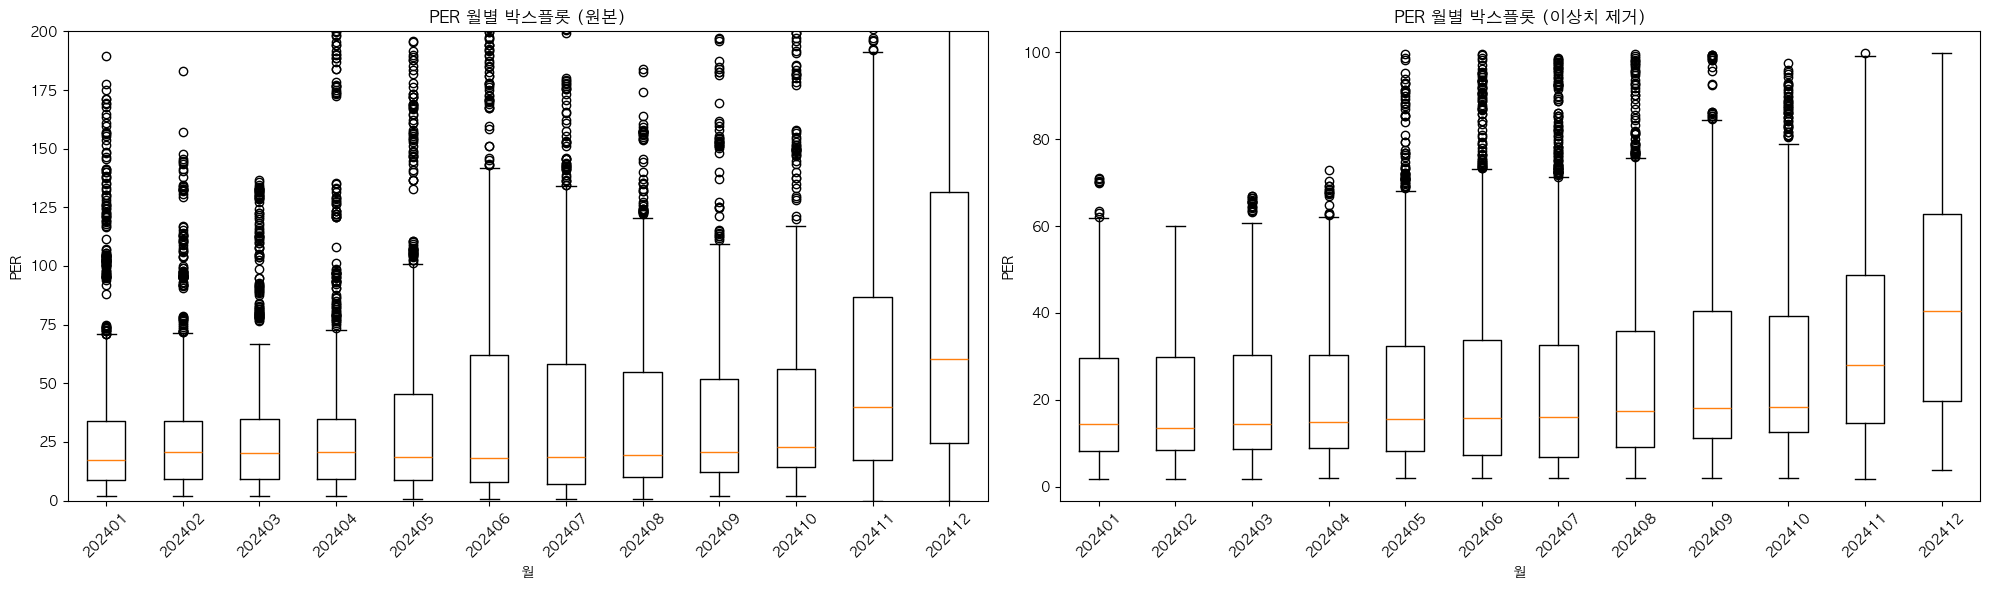

=== 이상치 제거 효과 ===
202401: 1540개 → 1370개 (170개 제거, 11.0%)
202402: 1330개 → 1178개 (152개 제거, 11.4%)
202403: 1400개 → 1240개 (160개 제거, 11.4%)
202404: 1470개 → 1312개 (158개 제거, 10.7%)
202405: 1440개 → 1248개 (192개 제거, 13.3%)
202406: 1387개 → 1188개 (199개 제거, 14.3%)
202407: 1679개 → 1439개 (240개 제거, 14.3%)
202408: 1569개 → 1363개 (206개 제거, 13.1%)
202409: 1367개 → 1201개 (166개 제거, 12.1%)
202410: 1500개 → 1320개 (180개 제거, 12.0%)
202411: 1498개 → 1153개 (345개 제거, 23.0%)
202412: 1360개 → 904개 (456개 제거, 33.5%)


In [199]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def remove_outliers_iqr(data, factor=1.5):
    """IQR 방법으로 이상치 제거"""
    if len(data) == 0:
        return data
    
    data_array = np.array(data)
    Q1 = np.percentile(data_array, 25)
    Q3 = np.percentile(data_array, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    # PER 특성상 최소 1, 최대 100으로 제한
    lower_bound = max(lower_bound, 1)
    upper_bound = min(upper_bound, 100)
    
    filtered_data = [x for x in data_array if lower_bound <= x <= upper_bound]
    return filtered_data

# PER 데이터 추출
per_data = filter_metric_analysis(analysis_df, 'PER')
date_cols = [col for col in per_data.columns if col.isdigit() and len(col) == 8]

# 월별 데이터 수집 및 이상치 제거
monthly_data_clean = {}
for date in date_cols:
    month = date[:6]  # YYYYMM
    if month not in monthly_data_clean:
        monthly_data_clean[month] = []
    
    data = per_data[date].dropna().tolist()
    if len(data) > 0:
        # 해당 날짜 데이터에서 이상치 제거
        clean_data = remove_outliers_iqr(data)
        monthly_data_clean[month].extend(clean_data)

# 월별 박스플롯 (이상치 제거 후)
months = sorted(monthly_data_clean.keys())
month_data_clean = [monthly_data_clean[month] for month in months]

# 원본과 이상치 제거 후 비교
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# 원본 데이터
monthly_data_orig = {}
for date in date_cols:
    month = date[:6]
    if month not in monthly_data_orig:
        monthly_data_orig[month] = []
    data = per_data[date].dropna().tolist()
    if len(data) > 0:
        monthly_data_orig[month].extend(data)

month_data_orig = [monthly_data_orig[month] for month in months]

# 원본 박스플롯
ax1.boxplot(month_data_orig, labels=months)
ax1.set_title('PER 월별 박스플롯 (원본)')
ax1.set_xlabel('월')
ax1.set_ylabel('PER')
ax1.tick_params(axis='x', rotation=45)
ax1.set_ylim(0, 200)  # y축 제한으로 보기 쉽게

# 이상치 제거 후 박스플롯
ax2.boxplot(month_data_clean, labels=months)
ax2.set_title('PER 월별 박스플롯 (이상치 제거)')
ax2.set_xlabel('월')
ax2.set_ylabel('PER')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# 이상치 제거 효과 출력
print("=== 이상치 제거 효과 ===")
for i, month in enumerate(months):
    orig_count = len(month_data_orig[i])
    clean_count = len(month_data_clean[i])
    removed = orig_count - clean_count
    print(f"{month}: {orig_count}개 → {clean_count}개 ({removed}개 제거, {removed/orig_count*100:.1f}%)")

처리 중: PER
=== PER 이상치 제거 효과 ===
전체: 17540개 → 15519개 (2021개 제거, 11.5%)
처리 중: PBR
=== PBR 이상치 제거 효과 ===
전체: 25132개 → 22677개 (2455개 제거, 9.8%)
처리 중: ROE
=== ROE 이상치 제거 효과 ===
전체: 25132개 → 21691개 (3441개 제거, 13.7%)
처리 중: ROA
=== ROA 이상치 제거 효과 ===
전체: 25132개 → 22446개 (2686개 제거, 10.7%)
처리 중: 영업이익률
=== 영업이익률 이상치 제거 효과 ===
전체: 25132개 → 21022개 (4110개 제거, 16.4%)
처리 중: 부채비율
=== 부채비율 이상치 제거 효과 ===
전체: 25132개 → 22626개 (2506개 제거, 10.0%)


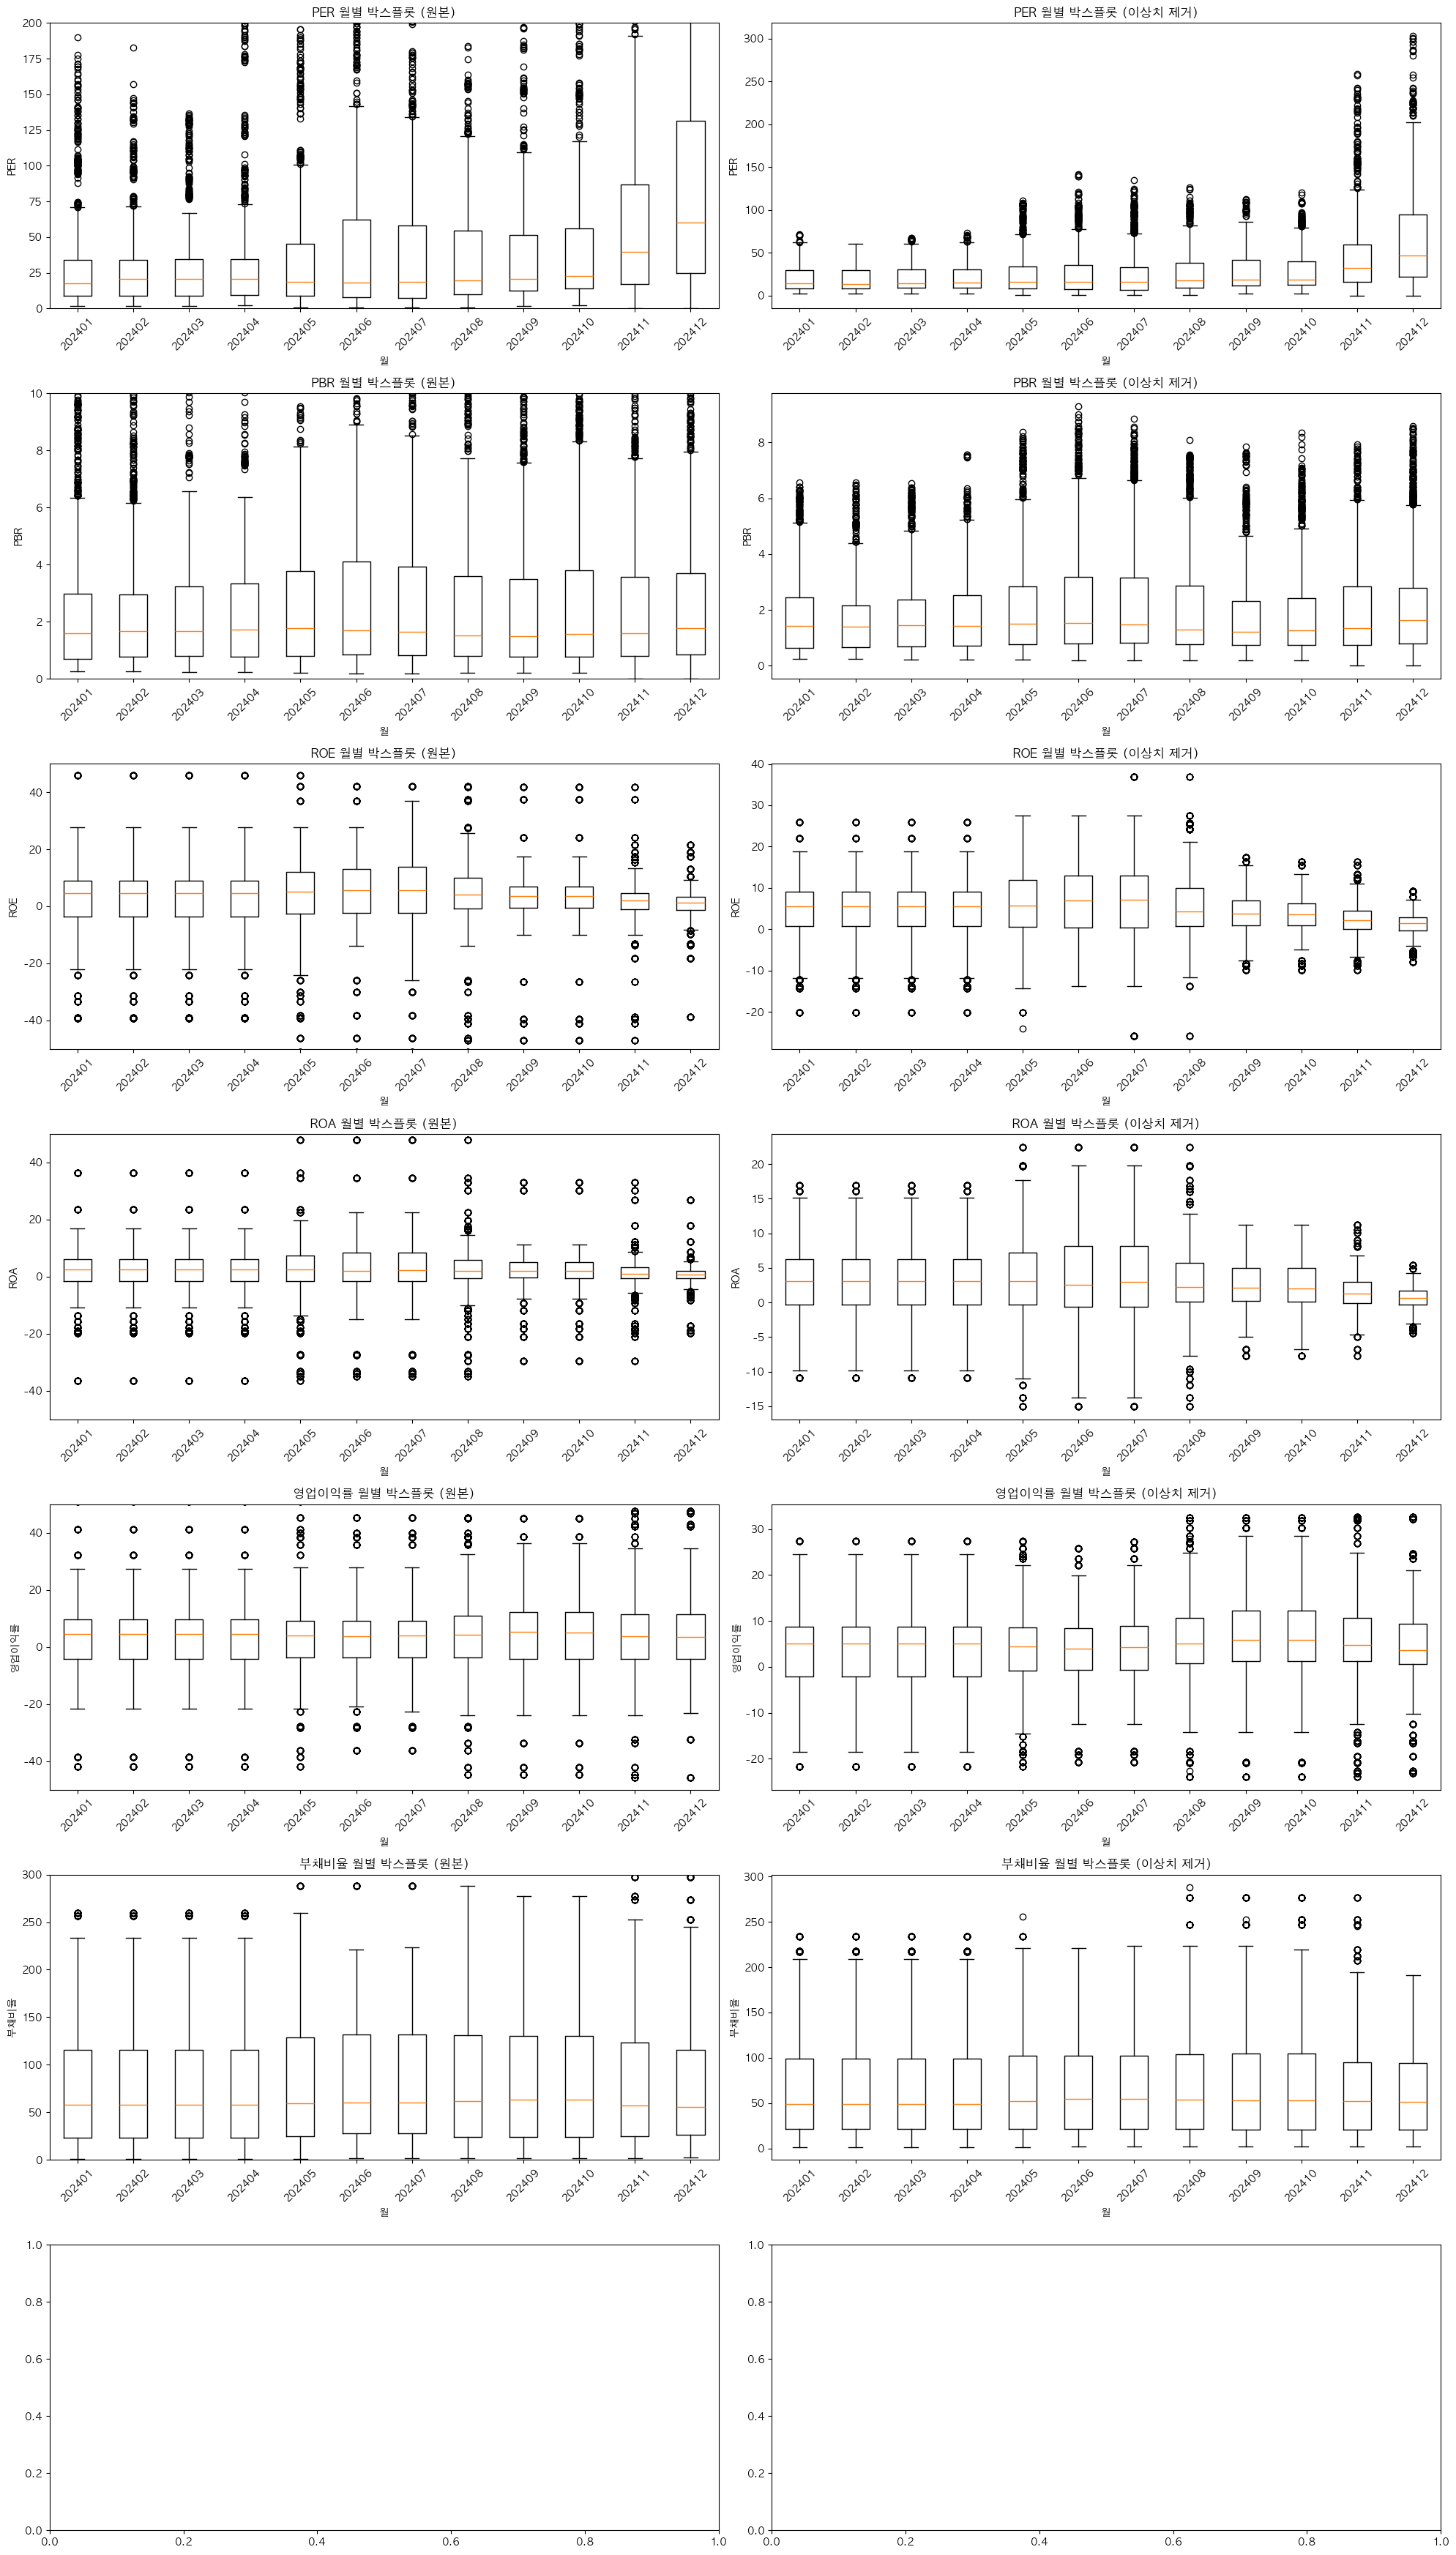


=== 전체 지표 이상치 제거 요약 ===
PER: 2021개 제거 (11.5%)
PBR: 2455개 제거 (9.8%)
ROE: 3441개 제거 (13.7%)
ROA: 2686개 제거 (10.7%)
영업이익률: 4110개 제거 (16.4%)
부채비율: 2506개 제거 (10.0%)


In [202]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def remove_outliers_iqr(data, factor=1.5):
    """IQR 방법으로 이상치 제거"""
    if len(data) == 0:
        return data
    
    data_array = np.array(data)
    Q1 = np.percentile(data_array, 25)
    Q3 = np.percentile(data_array, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    filtered_data = [x for x in data_array if lower_bound <= x <= upper_bound]
    return filtered_data

# 모든 지표 리스트
metrics = ['PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']

# 7행 2열 서브플롯 생성
fig, axes = plt.subplots(7, 2, figsize=(20, 35))

for row, metric in enumerate(metrics):
    print(f"처리 중: {metric}")
    
    # 해당 지표 데이터 추출
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # 월별 데이터 수집 (원본)
    monthly_data_orig = {}
    for date in date_cols:
        month = date[:6]
        if month not in monthly_data_orig:
            monthly_data_orig[month] = []
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            monthly_data_orig[month].extend(data)
    
    # 월별 데이터 수집 (이상치 제거)
    monthly_data_clean = {}
    for date in date_cols:
        month = date[:6]
        if month not in monthly_data_clean:
            monthly_data_clean[month] = []
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            clean_data = remove_outliers_iqr(data)
            monthly_data_clean[month].extend(clean_data)
    
    months = sorted(monthly_data_orig.keys())
    month_data_orig = [monthly_data_orig[month] for month in months]
    month_data_clean = [monthly_data_clean[month] for month in months]
    
    # 원본 박스플롯 (좌측)
    axes[row, 0].boxplot(month_data_orig, labels=months)
    axes[row, 0].set_title(f'{metric} 월별 박스플롯 (원본)')
    axes[row, 0].set_xlabel('월')
    axes[row, 0].set_ylabel(metric)
    axes[row, 0].tick_params(axis='x', rotation=45)
    
    # Y축 범위 설정 (지표별 조정)
    if metric == 'PER':
        axes[row, 0].set_ylim(0, 200)
    elif metric == 'PBR':
        axes[row, 0].set_ylim(0, 10)
    elif metric in ['ROE', 'ROA']:
        axes[row, 0].set_ylim(-50, 50)
    elif metric == '영업이익률':
        axes[row, 0].set_ylim(-50, 50)
    elif metric == '부채비율':
        axes[row, 0].set_ylim(0, 300)
    
    # 이상치 제거 후 박스플롯 (우측)
    axes[row, 1].boxplot(month_data_clean, labels=months)
    axes[row, 1].set_title(f'{metric} 월별 박스플롯 (이상치 제거)')
    axes[row, 1].set_xlabel('월')
    axes[row, 1].set_ylabel(metric)
    axes[row, 1].tick_params(axis='x', rotation=45)
    
    # 이상치 제거 효과 출력
    print(f"=== {metric} 이상치 제거 효과 ===")
    total_orig = sum(len(data) for data in month_data_orig)
    total_clean = sum(len(data) for data in month_data_clean)
    total_removed = total_orig - total_clean
    print(f"전체: {total_orig}개 → {total_clean}개 ({total_removed}개 제거, {total_removed/total_orig*100:.1f}%)")

plt.tight_layout()
plt.show()

# 전체 요약 통계
print("\n=== 전체 지표 이상치 제거 요약 ===")
for metric in metrics:
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    total_orig = 0
    total_clean = 0
    
    for date in date_cols:
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            total_orig += len(data)
            clean_data = remove_outliers_iqr(data)
            total_clean += len(clean_data)
    
    removed = total_orig - total_clean
    if total_orig > 0:
        print(f"{metric}: {removed}개 제거 ({removed/total_orig*100:.1f}%)")

처리 중: PER
=== PER 이상치 제거 효과 ===
전체: 17540개 → 15519개 (2021개 제거, 11.5%)
처리 중: PBR
=== PBR 이상치 제거 효과 ===
전체: 25132개 → 22677개 (2455개 제거, 9.8%)
처리 중: ROE
=== ROE 이상치 제거 효과 ===
전체: 25132개 → 21691개 (3441개 제거, 13.7%)
처리 중: ROA
=== ROA 이상치 제거 효과 ===
전체: 25132개 → 22446개 (2686개 제거, 10.7%)
처리 중: 영업이익률
=== 영업이익률 이상치 제거 효과 ===
전체: 25132개 → 21022개 (4110개 제거, 16.4%)
처리 중: 부채비율
=== 부채비율 이상치 제거 효과 ===
전체: 25132개 → 22626개 (2506개 제거, 10.0%)


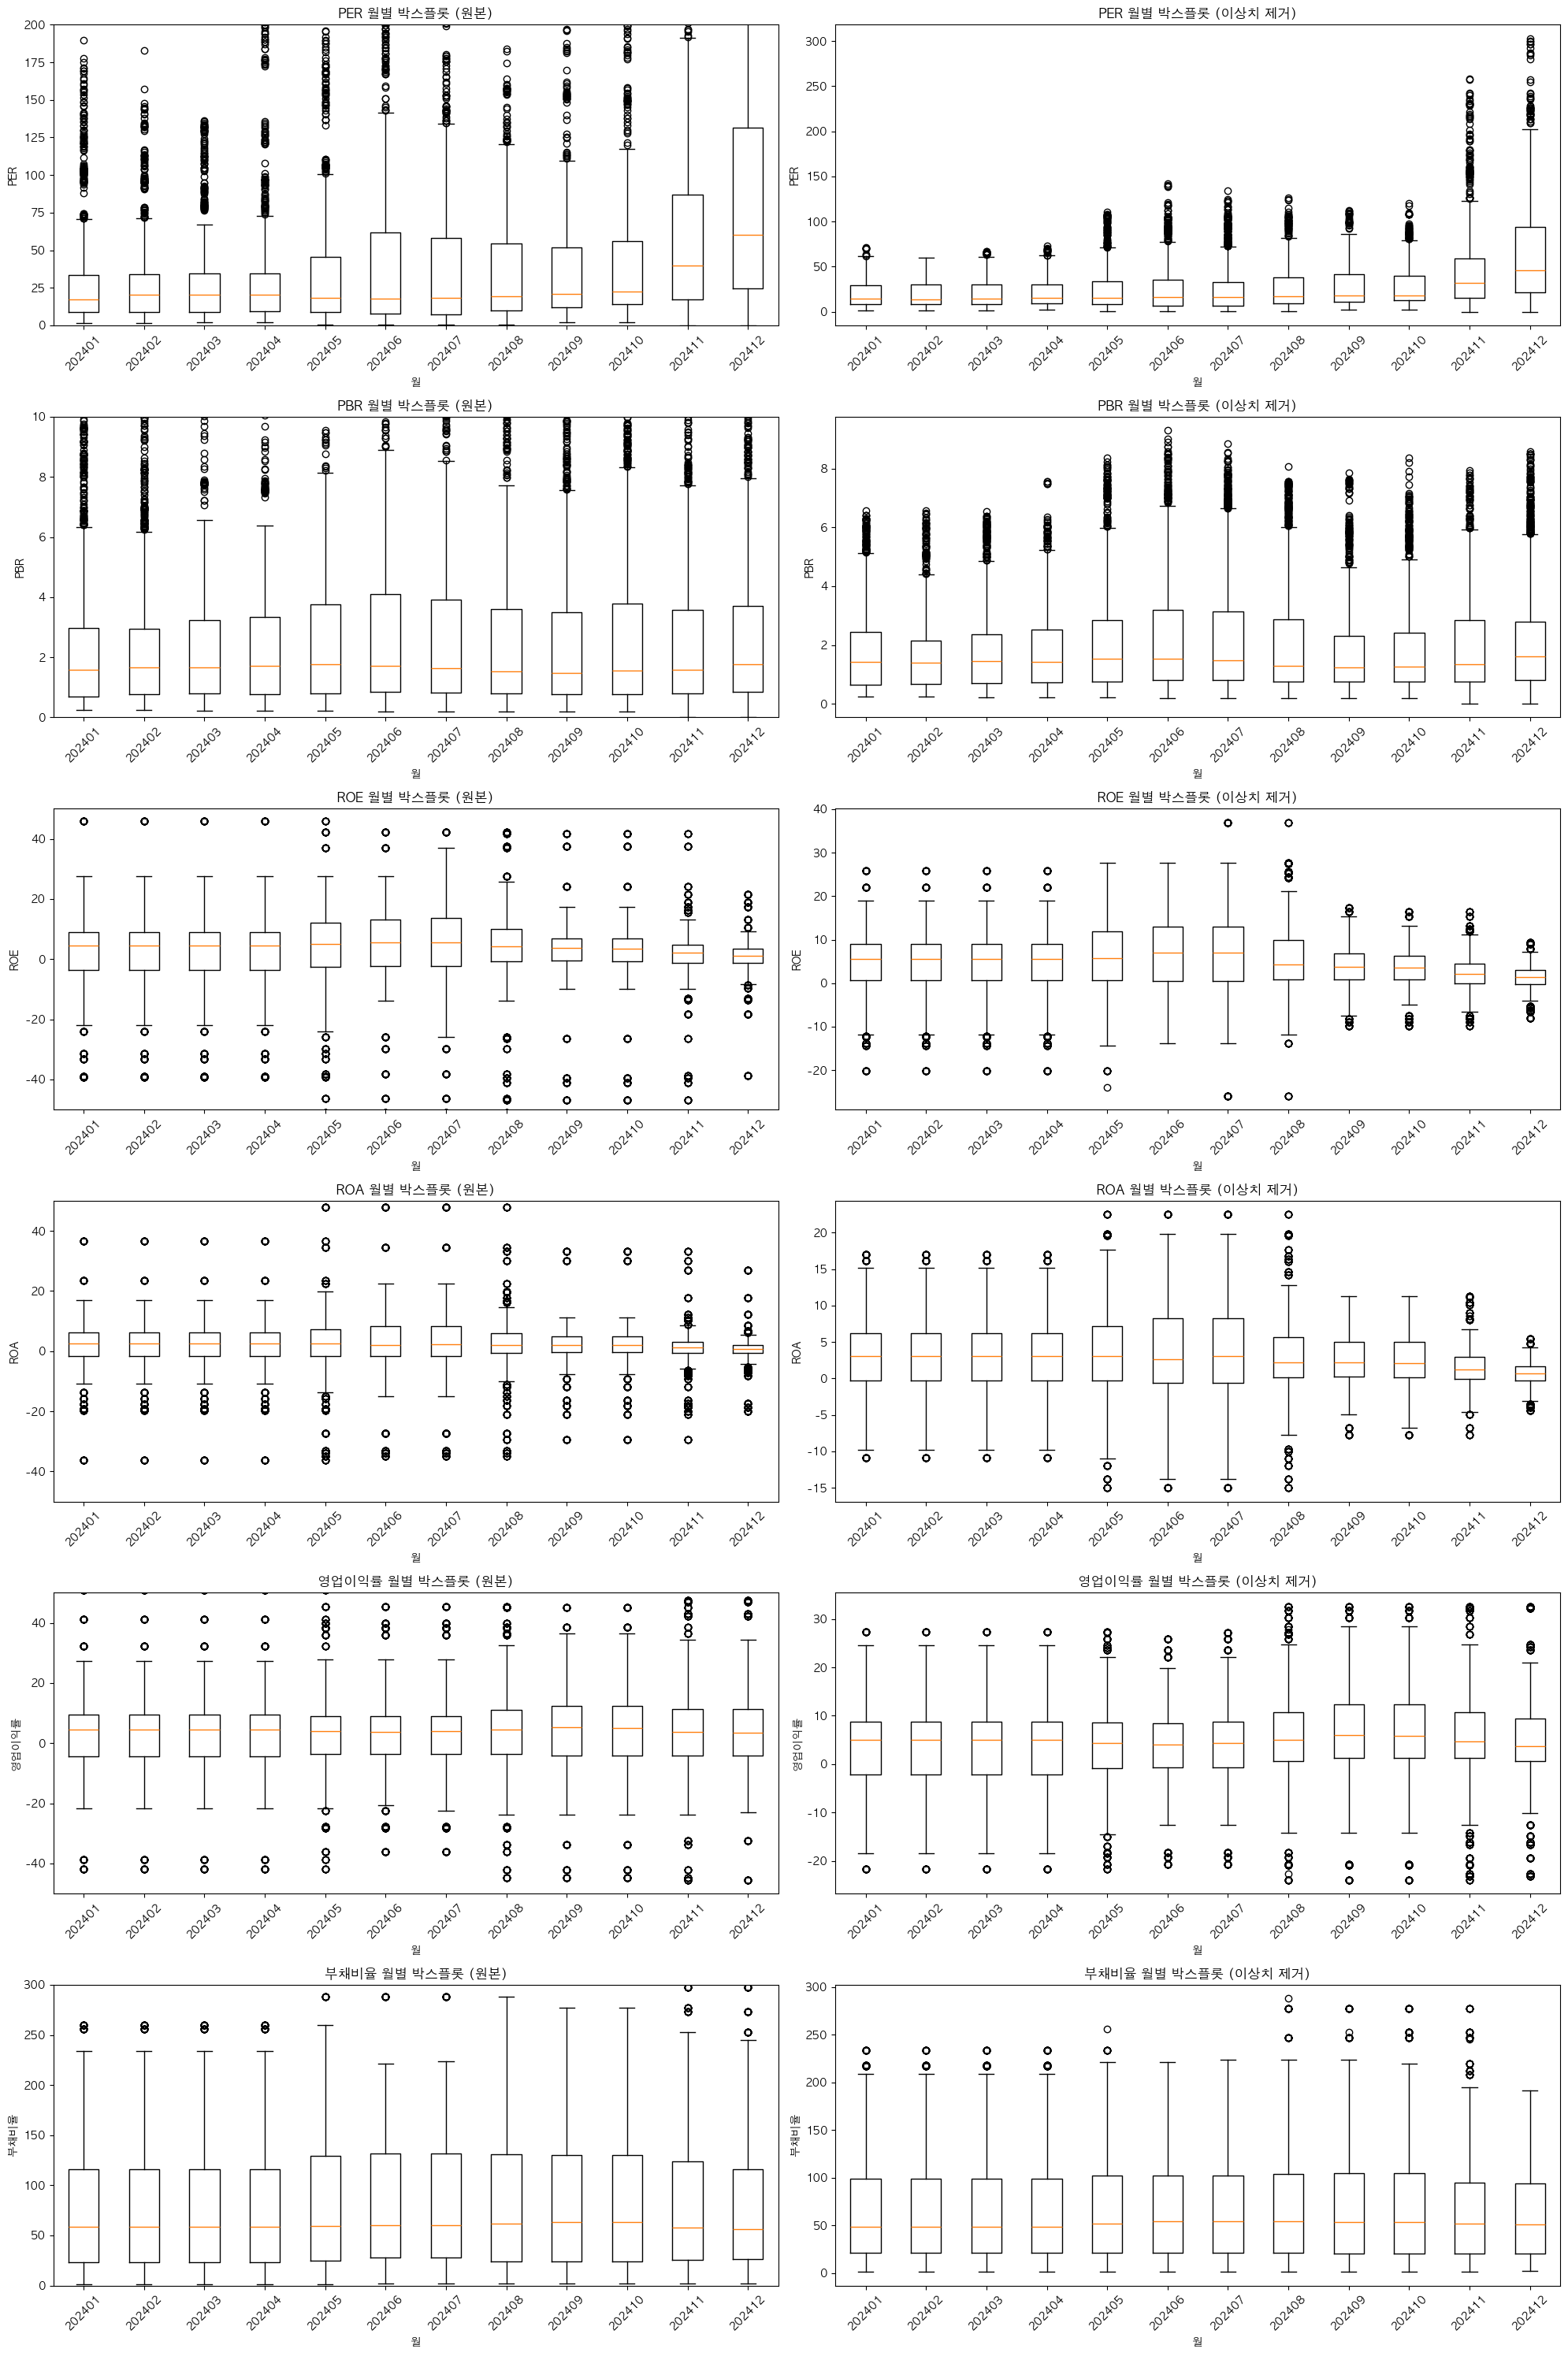


=== 전체 지표 이상치 제거 요약 ===
PER: 2021개 제거 (11.5%)
PBR: 2455개 제거 (9.8%)
ROE: 3441개 제거 (13.7%)
ROA: 2686개 제거 (10.7%)
영업이익률: 4110개 제거 (16.4%)
부채비율: 2506개 제거 (10.0%)

🎯 이상치 제거 후 투자 구간 분석 (매수/매도 지점 참고)
   지표  Lower_Bound  Q1_매수적극  Median_적정  Mean_평균  Q3_매도검토  Upper_Bound  정제데이터수
  PER       -31.92     9.09      18.42    28.93    36.43        77.43   15519
  PBR        -2.07     0.75       1.41     1.97     2.63         5.45   22677
  ROE       -12.59     0.31       4.18     4.49     8.91        21.81   21691
  ROA        -8.47    -0.02       2.11     2.71     5.62        14.07   22446
영업이익률       -14.18     0.07       4.90     4.68     9.57        23.82   21022
 부채비율       -99.36    21.14      51.75    68.09   101.47       221.97   22626

📊 투자 구간 해석 가이드:
Lower_Bound ~ Q1     : 🟢 매수 적극 고려 (저평가 구간)
Q1 ~ Median         : 🟡 매수 검토 (적정 하단)
Median ~ Mean       : 🟠 보유/관망 (적정 중간)
Mean ~ Q3           : 🔴 매도 검토 (적정 상단)
Q3 ~ Upper_Bound    : 🔴 매도 적극 고려 (고평가 구간)
Upper_Bound 초과    : ⛔ 투자 금지 (극도 고평가)

💡 실전 활

In [206]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def remove_outliers_iqr(data, factor=1.5):
    """IQR 방법으로 이상치 제거"""
    if len(data) == 0:
        return data
    
    data_array = np.array(data)
    Q1 = np.percentile(data_array, 25)
    Q3 = np.percentile(data_array, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    filtered_data = [x for x in data_array if lower_bound <= x <= upper_bound]
    return filtered_data

# 모든 지표 리스트
metrics = ['PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']

# 7행 2열 서브플롯 생성
fig, axes = plt.subplots(6, 2, figsize=(20, 30))

for row, metric in enumerate(metrics):
    print(f"처리 중: {metric}")
    
    # 해당 지표 데이터 추출
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # 월별 데이터 수집 (원본)
    monthly_data_orig = {}
    for date in date_cols:
        month = date[:6]
        if month not in monthly_data_orig:
            monthly_data_orig[month] = []
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            monthly_data_orig[month].extend(data)
    
    # 월별 데이터 수집 (이상치 제거)
    monthly_data_clean = {}
    for date in date_cols:
        month = date[:6]
        if month not in monthly_data_clean:
            monthly_data_clean[month] = []
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            clean_data = remove_outliers_iqr(data)
            monthly_data_clean[month].extend(clean_data)
    
    months = sorted(monthly_data_orig.keys())
    month_data_orig = [monthly_data_orig[month] for month in months]
    month_data_clean = [monthly_data_clean[month] for month in months]
    
    # 원본 박스플롯 (좌측)
    axes[row, 0].boxplot(month_data_orig, labels=months)
    axes[row, 0].set_title(f'{metric} 월별 박스플롯 (원본)')
    axes[row, 0].set_xlabel('월')
    axes[row, 0].set_ylabel(metric)
    axes[row, 0].tick_params(axis='x', rotation=45)
    
    # Y축 범위 설정 (지표별 조정)
    if metric == 'PER':
        axes[row, 0].set_ylim(0, 200)
    elif metric == 'PBR':
        axes[row, 0].set_ylim(0, 10)
    elif metric in ['ROE', 'ROA']:
        axes[row, 0].set_ylim(-50, 50)
    elif metric == '영업이익률':
        axes[row, 0].set_ylim(-50, 50)
    elif metric == '부채비율':
        axes[row, 0].set_ylim(0, 300)
    
    # 이상치 제거 후 박스플롯 (우측)
    axes[row, 1].boxplot(month_data_clean, labels=months)
    axes[row, 1].set_title(f'{metric} 월별 박스플롯 (이상치 제거)')
    axes[row, 1].set_xlabel('월')
    axes[row, 1].set_ylabel(metric)
    axes[row, 1].tick_params(axis='x', rotation=45)
    
    # 이상치 제거 효과 출력
    print(f"=== {metric} 이상치 제거 효과 ===")
    total_orig = sum(len(data) for data in month_data_orig)
    total_clean = sum(len(data) for data in month_data_clean)
    total_removed = total_orig - total_clean
    print(f"전체: {total_orig}개 → {total_clean}개 ({total_removed}개 제거, {total_removed/total_orig*100:.1f}%)")

plt.tight_layout()
plt.show()

# 전체 요약 통계
print("\n=== 전체 지표 이상치 제거 요약 ===")
for metric in metrics:
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    total_orig = 0
    total_clean = 0
    
    for date in date_cols:
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            total_orig += len(data)
            clean_data = remove_outliers_iqr(data)
            total_clean += len(clean_data)
    
    removed = total_orig - total_clean
    if total_orig > 0:
        print(f"{metric}: {removed}개 제거 ({removed/total_orig*100:.1f}%)")

# ============== 여기서부터 추가된 부분 ==============

print("\n" + "="*100)
print("🎯 이상치 제거 후 투자 구간 분석 (매수/매도 지점 참고)")
print("="*100)

# 이상치 제거된 데이터로 투자 구간 분석
investment_analysis = []

for metric in metrics:
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # 이상치 제거된 전체 데이터 수집
    all_clean_data = []
    for date in date_cols:
        data = metric_data[date].dropna().tolist()
        if len(data) > 0:
            clean_data = remove_outliers_iqr(data)
            all_clean_data.extend(clean_data)
    
    if len(all_clean_data) > 0:
        Q1 = np.percentile(all_clean_data, 25)
        Q3 = np.percentile(all_clean_data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        median = np.median(all_clean_data)
        mean = np.mean(all_clean_data)
        
        investment_analysis.append({
            '지표': metric,
            'Lower_Bound': round(lower_bound, 2),
            'Q1_매수적극': round(Q1, 2),
            'Median_적정': round(median, 2),
            'Mean_평균': round(mean, 2),
            'Q3_매도검토': round(Q3, 2),
            'Upper_Bound': round(upper_bound, 2),
            '정제데이터수': len(all_clean_data)
        })

# 투자 구간 분석 테이블 출력
investment_df = pd.DataFrame(investment_analysis)
print(investment_df.to_string(index=False))

print(f"\n📊 투자 구간 해석 가이드:")
print(f"Lower_Bound ~ Q1     : 🟢 매수 적극 고려 (저평가 구간)")
print(f"Q1 ~ Median         : 🟡 매수 검토 (적정 하단)")  
print(f"Median ~ Mean       : 🟠 보유/관망 (적정 중간)")
print(f"Mean ~ Q3           : 🔴 매도 검토 (적정 상단)")
print(f"Q3 ~ Upper_Bound    : 🔴 매도 적극 고려 (고평가 구간)")
print(f"Upper_Bound 초과    : ⛔ 투자 금지 (극도 고평가)")

# 실전 투자 활용 예시
print(f"\n💡 실전 활용 예시:")
for _, row in investment_df.iterrows():
    metric = row['지표']
    if metric == 'PER':
        print(f"📈 {metric}: {row['Q1_매수적극']}배 이하 매수, {row['Q3_매도검토']}배 이상 매도")
    elif metric == 'PBR':
        print(f"📊 {metric}: {row['Q1_매수적극']}배 이하 매수, {row['Q3_매도검토']}배 이상 매도")
    elif metric == 'ROE':
        print(f"💰 {metric}: {row['Q1_매수적극']}% 이상 선호, {row['Median_적정']}% 적정")

In [203]:
# 간단한 요약 테이블
metrics = ['종가', 'PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']
bounds_summary = []

for metric in metrics:
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # 전체 데이터 수집
    all_data = []
    for date in date_cols:
        data = metric_data[date].dropna().tolist()
        all_data.extend(data)
    
    if len(all_data) > 0:
        Q1 = np.percentile(all_data, 25)
        Q3 = np.percentile(all_data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        bounds_summary.append({
            '지표': metric,
            'Q1': round(Q1, 2),
            'Q3': round(Q3, 2), 
            'IQR': round(IQR, 2),
            'Lower_Bound': round(lower_bound, 2),
            'Upper_Bound': round(upper_bound, 2)
        })

# 표로 출력
bounds_table = pd.DataFrame(bounds_summary)
print("=== 지표별 이상치 경계값 요약 ===")
print(bounds_table.to_string(index=False))

=== 지표별 이상치 경계값 요약 ===
   지표      Q1       Q3      IQR  Lower_Bound  Upper_Bound
   종가 3415.00 21850.00 18435.00    -24237.50     49502.50
  PER    9.98    52.03    42.05       -53.09       115.10
  PBR    0.79     3.56     2.77        -3.36         7.72
  ROE   -1.79     8.91    10.70       -17.84        24.96
  ROA   -0.79     5.69     6.48       -10.51        15.40
영업이익률   -3.87     9.99    13.86       -24.66        30.79
 부채비율   24.22   123.69    99.47      -124.99       272.89


In [204]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def get_outlier_bounds(data, factor=1.5):
    """이상치 경계값 계산"""
    if len(data) == 0:
        return None, None, None, None
    
    data_array = np.array(data)
    Q1 = np.percentile(data_array, 25)
    Q3 = np.percentile(data_array, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    
    return Q1, Q3, lower_bound, upper_bound

# 모든 지표 리스트
metrics = ['종가', 'PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']

# 결과를 저장할 딕셔너리
bounds_results = {}

for metric in metrics:
    print(f"\n=== {metric} 월별 이상치 경계값 ===")
    
    # 해당 지표 데이터 추출
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # 월별 경계값 계산
    monthly_bounds = []
    
    for date in date_cols:
        month = date[:6]
        data = metric_data[date].dropna().tolist()
        
        if len(data) > 0:
            Q1, Q3, lower_bound, upper_bound = get_outlier_bounds(data)
            monthly_bounds.append({
                '날짜': date,
                '월': month,
                'Q1': Q1,
                'Q3': Q3,
                'Lower_Bound': lower_bound,
                'Upper_Bound': upper_bound,
                '데이터수': len(data)
            })
    
    # DataFrame으로 변환
    bounds_df = pd.DataFrame(monthly_bounds)
    
    # 월별로 그룹화하여 평균 계산
    monthly_summary = bounds_df.groupby('월').agg({
        'Q1': 'mean',
        'Q3': 'mean', 
        'Lower_Bound': 'mean',
        'Upper_Bound': 'mean',
        '데이터수': 'sum'
    }).round(2)
    
    bounds_results[metric] = monthly_summary
    
    # 표 출력
    print(monthly_summary.to_string())

# 전체 요약 테이블 생성
print("\n" + "="*100)
print("전체 지표별 월별 이상치 경계값 요약")
print("="*100)

# 모든 지표를 하나의 큰 테이블로 만들기
summary_table = []

for metric in metrics:
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # 전체 기간 통계
    all_data = []
    for date in date_cols:
        data = metric_data[date].dropna().tolist()
        all_data.extend(data)
    
    if len(all_data) > 0:
        Q1, Q3, lower_bound, upper_bound = get_outlier_bounds(all_data)
        summary_table.append({
            '지표': metric,
            'Q1': round(Q1, 2),
            'Q3': round(Q3, 2),
            'Lower_Bound': round(lower_bound, 2),
            'Upper_Bound': round(upper_bound, 2),
            '전체_데이터수': len(all_data)
        })

summary_df = pd.DataFrame(summary_table)
print(summary_df.to_string(index=False))

# 각 지표별 세부 월별 테이블도 저장
print(f"\n각 지표별 상세 월별 경계값:")
for metric, bounds_df in bounds_results.items():
    print(f"\n--- {metric} ---")
    print(bounds_df.to_string())


=== 종가 월별 이상치 경계값 ===
             Q1        Q3  Lower_Bound  Upper_Bound  데이터수
월                                                        
202401  3132.16  18683.64    -20195.06     42010.85  2266
202402  3328.95  19797.63    -21374.08     44500.66  1957
202403  3320.75  20515.75    -22471.75     46308.25  2060
202404  3308.21  20445.48    -22397.68     46151.37  2163
202405  3512.00  20808.50    -22432.75     46753.25  2060
202406  3608.55  21644.74    -23445.72     48699.01  1957
202407  3656.74  22743.48    -24973.37     51373.59  2369
202408  3288.21  21002.14    -23282.68     47573.04  2163
202409  3347.22  21725.56    -24220.28     49293.06  1854
202410  3362.88  22825.00    -25830.31     52018.19  2060
202411  3619.88  22190.00    -24235.30     50045.18  2163
202412  4055.75  23635.00    -25313.12     53003.88  2060

=== PER 월별 이상치 경계값 ===
           Q1      Q3  Lower_Bound  Upper_Bound  데이터수
월                                                    
202401   9.00   33.63       -27.9

In [205]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def get_investment_bounds(data, factor=1.5):
    """투자 지점 분석용 통계값 계산"""
    if len(data) == 0:
        return None
    
    data_array = np.array(data)
    Q1 = np.percentile(data_array, 25)
    Q3 = np.percentile(data_array, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    median = np.median(data_array)
    mean = np.mean(data_array)
    
    return {
        'Q1': Q1,
        'Q3': Q3,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'Median': median,
        'Mean': mean,
        'Count': len(data_array)
    }

# 모든 지표 리스트
metrics = ['종가', 'PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']

print("="*120)
print("지표별 투자 구간 분석 (매수/매도 지점 참고)")
print("="*120)

investment_summary = []

for metric in metrics:
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    # 전체 데이터 수집
    all_data = []
    for date in date_cols:
        data = metric_data[date].dropna().tolist()
        all_data.extend(data)
    
    if len(all_data) > 0:
        stats = get_investment_bounds(all_data)
        
        investment_summary.append({
            '지표': metric,
            'Lower_Bound': round(stats['Lower_Bound'], 2),
            'Q1': round(stats['Q1'], 2),
            'Median': round(stats['Median'], 2),
            'Mean': round(stats['Mean'], 2),
            'Q3': round(stats['Q3'], 2),
            'Upper_Bound': round(stats['Upper_Bound'], 2),
            '데이터수': stats['Count']
        })

# 투자 구간 분석 테이블
investment_df = pd.DataFrame(investment_summary)
print(investment_df.to_string(index=False))

print(f"\n📊 투자 구간 해석:")
print(f"Lower_Bound ~ Q1    : 🟢 매수 적극 고려 (저평가)")
print(f"Q1 ~ Median        : 🟡 매수 검토 (적정 하단)")  
print(f"Median ~ Mean      : 🟠 보유/관망 (적정 구간)")
print(f"Mean ~ Q3          : 🔴 매도 검토 (적정 상단)")
print(f"Q3 ~ Upper_Bound   : 🔴 매도 적극 고려 (고평가)")
print(f"Upper_Bound 초과   : ⛔ 투자 금지 (극도 고평가)")

# 월별 상세 분석도 제공
print(f"\n" + "="*80)
print("월별 상세 투자 구간 분석")
print("="*80)

for metric in ['PER', 'PBR', 'ROE']:  # 주요 지표만
    print(f"\n--- {metric} 월별 분석 ---")
    
    metric_data = filter_metric_analysis(analysis_df, metric)
    date_cols = [col for col in metric_data.columns if col.isdigit() and len(col) == 8]
    
    monthly_analysis = []
    
    # 월별 계산
    monthly_data = {}
    for date in date_cols:
        month = date[:6]
        if month not in monthly_data:
            monthly_data[month] = []
        data = metric_data[date].dropna().tolist()
        monthly_data[month].extend(data)
    
    for month, data in monthly_data.items():
        if len(data) > 0:
            stats = get_investment_bounds(data)
            monthly_analysis.append({
                '월': month,
                'Lower': round(stats['Lower_Bound'], 2),
                'Q1': round(stats['Q1'], 2),
                'Median': round(stats['Median'], 2),
                'Mean': round(stats['Mean'], 2),
                'Q3': round(stats['Q3'], 2),
                'Upper': round(stats['Upper_Bound'], 2)
            })
    
    monthly_df = pd.DataFrame(monthly_analysis)
    print(monthly_df.to_string(index=False))

지표별 투자 구간 분석 (매수/매도 지점 참고)
   지표  Lower_Bound      Q1  Median     Mean       Q3  Upper_Bound  데이터수
   종가    -24237.50 3415.00 8960.00 24871.95 21850.00     49502.50 25132
  PER       -53.09    9.98   22.36   249.60    52.03       115.10 17540
  PBR        -3.36    0.79    1.65     3.40     3.56         7.72 25132
  ROE       -17.84   -1.79    3.33    -5.63     8.91        24.96 25132
  ROA       -10.51   -0.79    1.96     1.28     5.69        15.40 25132
영업이익률       -24.66   -3.87    4.30   -37.91     9.99        30.79 25132
 부채비율      -124.99   24.22   58.86   135.19   123.69       272.89 25132

📊 투자 구간 해석:
Lower_Bound ~ Q1    : 🟢 매수 적극 고려 (저평가)
Q1 ~ Median        : 🟡 매수 검토 (적정 하단)
Median ~ Mean      : 🟠 보유/관망 (적정 구간)
Mean ~ Q3          : 🔴 매도 검토 (적정 상단)
Q3 ~ Upper_Bound   : 🔴 매도 적극 고려 (고평가)
Upper_Bound 초과   : ⛔ 투자 금지 (극도 고평가)

월별 상세 투자 구간 분석

--- PER 월별 분석 ---
     월   Lower    Q1  Median   Mean     Q3  Upper
202401  -28.32  8.92   17.45 462.74  33.75  71.00
202402  -28.51  9.00   20

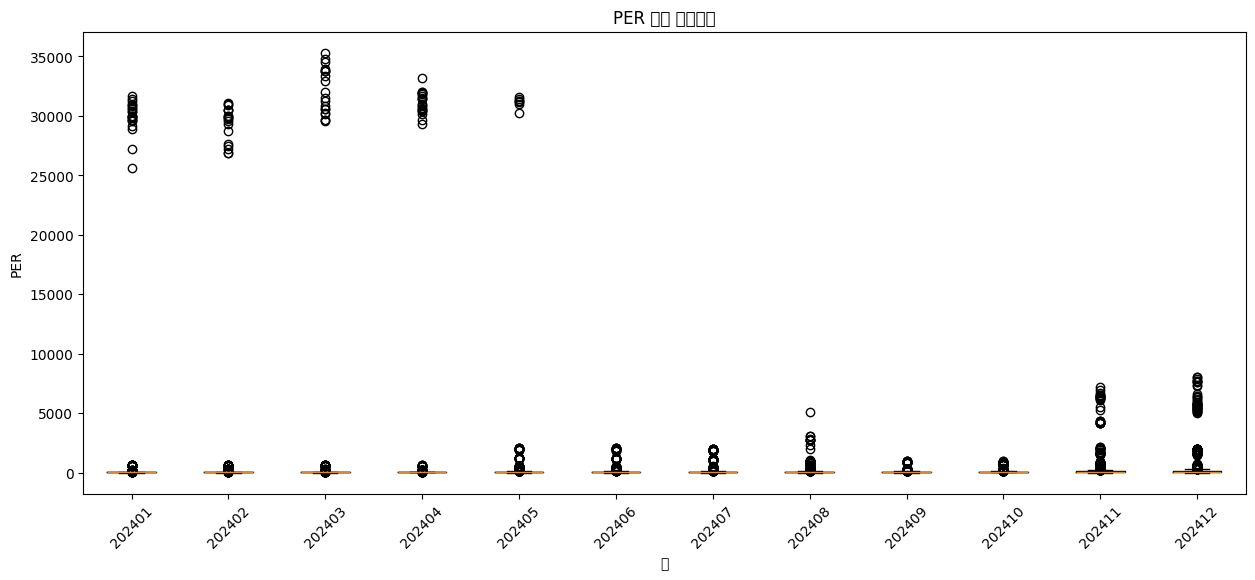

In [195]:
monthly_data = {}
for date in date_cols:
    month = date[:6]  # YYYYMM
    if month not in monthly_data:
        monthly_data[month] = []
    
    data = per_data[date].dropna()
    if len(data) > 0:
        monthly_data[month].extend(data.tolist())

# 월별 박스플롯
months = sorted(monthly_data.keys())
month_data = [monthly_data[month] for month in months]

plt.figure(figsize=(15, 6))
plt.boxplot(month_data, labels=months)
plt.title('PER 월별 박스플롯')
plt.xlabel('월')
plt.ylabel('PER')
plt.xticks(rotation=45)
plt.show()

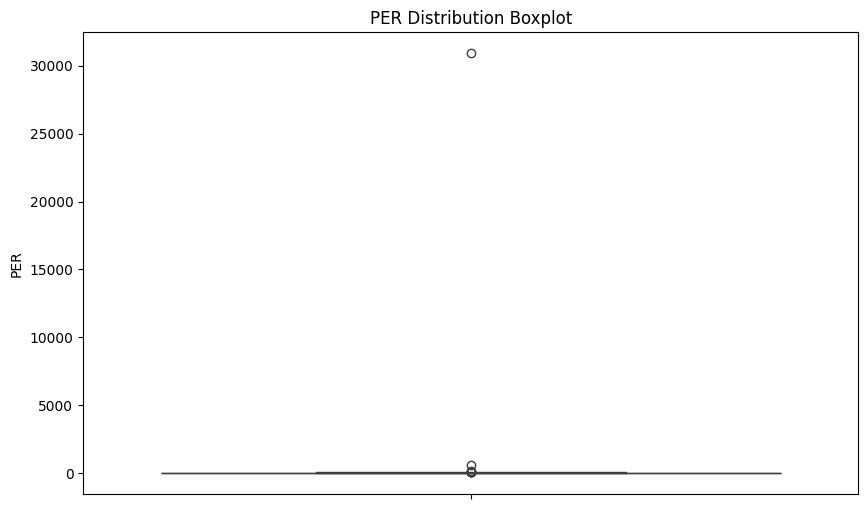

In [191]:
data = filter_metric_analysis(analysis_df, 'PER')['20240102']
data.describe()
plt.figure(figsize=(10, 6))
sns.boxplot(y=data.dropna())
plt.title('PER Distribution Boxplot')
plt.ylabel('PER')
plt.show()

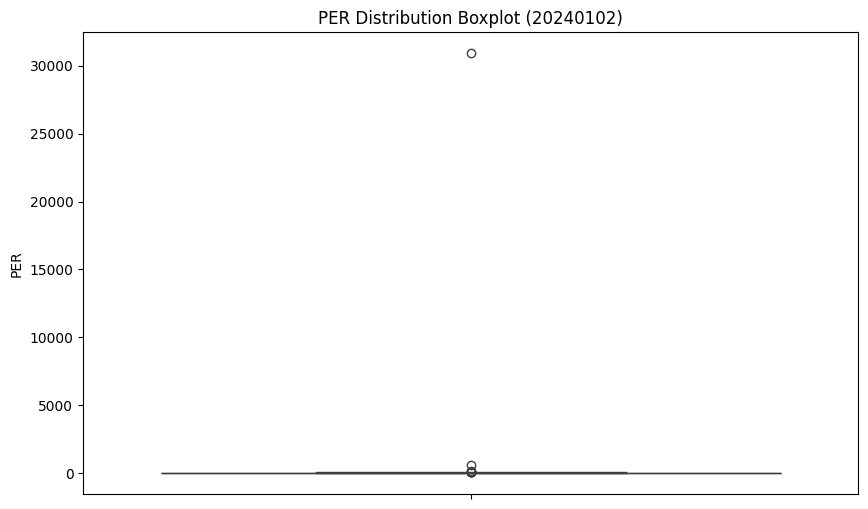

In [190]:
plt.figure(figsize=(10, 6))
sns.boxplot(y=data.dropna())
plt.title('PER Distribution Boxplot (20240102)')
plt.ylabel('PER')
plt.show()

🚀 퀀트 투자 전략 분석 시작
=== 데이터 로딩 및 전처리 ===
총 데이터 행수: 721
날짜 컬럼 수: 244
분석 기간: 20240102 ~ 20241230
구분 종류: ['종가', 'PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']
종목 수: 103

=== 수익률 계산 ===
평균 연간 수익률: 35.52%
중간값: 28.41%
최고 수익률: 178.94%
최저 수익률: -6.49%

=== 재무지표 데이터 추출 ===
재무지표 데이터 형태: (103, 6)

=== 종목 스크리닝 ===
스크리닝 통과 종목: 25개

=== 팩터 스코어 계산 ===
팩터 분석 완료 종목: 25개

=== 상위 20개 종목 포트폴리오 생성 ===

📊 분석 결과

🏆 상위 10개 추천 종목:
 1. 대명소노시즌          | 점수: 386605.814 | 수익률:   45.0%
 2. 유바이오로직스         | 점수: 10.330 | 수익률:   10.2%
 3. 티쓰리             | 점수:  9.736 | 수익률:   23.2%
 4. SK하이닉스          | 점수:  8.166 | 수익률:   22.1%
 5. 아이비김영           | 점수:  7.473 | 수익률:    8.0%
 6. 에이텍모빌리티         | 점수:  6.070 | 수익률:   17.0%
 7. 한글과컴퓨터          | 점수:  5.554 | 수익률:   45.1%
 8. 지엔씨에너지          | 점수:  4.571 | 수익률:   90.3%
 9. 비츠로셀            | 점수:  4.511 | 수익률:   25.0%
10. 서희건설            | 점수:  4.357 | 수익률:   16.4%

📈 동일가중 포트폴리오 성과:
   총수익률:  44.82%
   변동성:  19.78%
   샤프비율:   2.16%
   최대낙폭:  -9.33%

🎯 팩터가중 포트폴리오 성과:
   총수익률: 

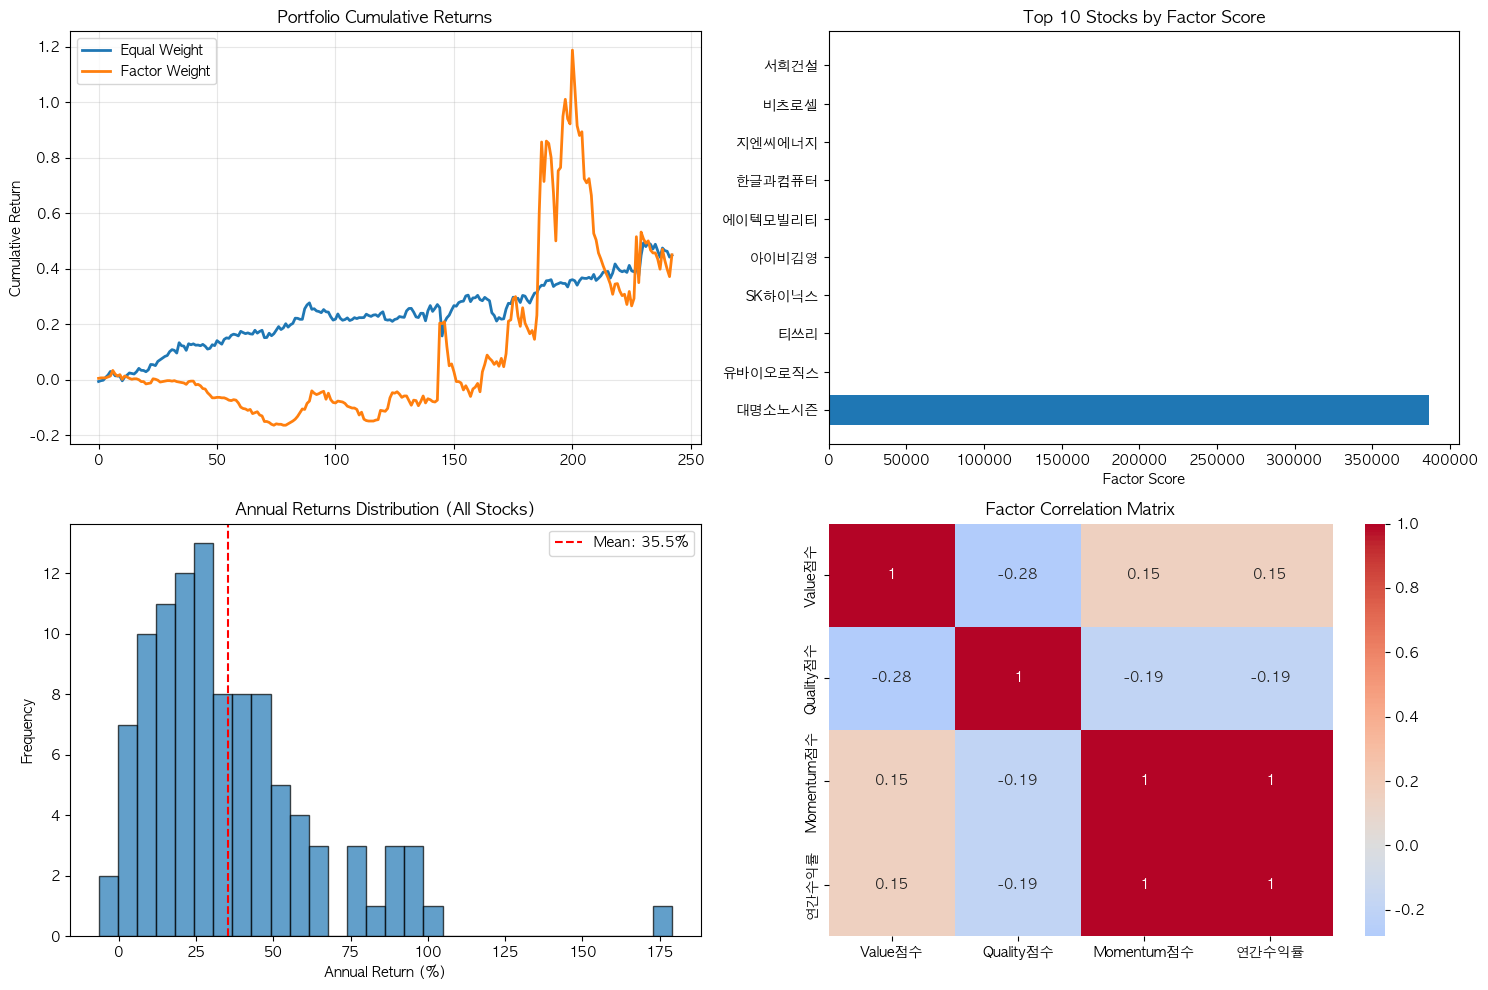


🎯 투자 전략 제안:
1. 상위 20개 종목으로 포트폴리오 구성
2. 분기별 리밸런싱 실시
3. 개별 종목 비중 5% 이하로 제한
4. 섹터 분산 고려하여 조정
5. 시장 상황에 따른 현금 비중 조절


In [177]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False

def load_and_prepare_data(file_path):
    """
    데이터 로드 및 전처리
    """
    print("=== 데이터 로딩 및 전처리 ===")
    
    # CSV 파일 읽기
    df = pd.read_csv(file_path, encoding='utf-8')
    
    # 날짜 컬럼 추출 (YYYYMMDD 형태)
    date_columns = [col for col in df.columns if re.match(r'^\d{8}$', col)]
    
    print(f"총 데이터 행수: {len(df)}")
    print(f"날짜 컬럼 수: {len(date_columns)}")
    print(f"분석 기간: {date_columns[0]} ~ {date_columns[-1]}")
    
    # 구분별 데이터 분리
    data_dict = {}
    for category in df['구분'].unique():
        data_dict[category] = df[df['구분'] == category].set_index('종목명')[date_columns]
    
    print(f"구분 종류: {list(data_dict.keys())}")
    print(f"종목 수: {len(data_dict['종가'])}")
    
    return data_dict, date_columns

def calculate_stock_returns(price_data, date_columns):
    """
    종목별 수익률 계산
    """
    print("\n=== 수익률 계산 ===")
    
    # 연간 수익률 계산
    annual_returns = {}
    for stock in price_data.index:
        try:
            start_price = price_data.loc[stock, date_columns[0]]
            end_price = price_data.loc[stock, date_columns[-1]]
            
            if pd.notna(start_price) and pd.notna(end_price) and start_price > 0:
                annual_return = (end_price / start_price - 1) * 100
                annual_returns[stock] = annual_return
        except:
            continue
    
    # 일별 수익률 계산
    daily_returns = price_data.pct_change(axis=1)
    
    # 통계 출력
    returns_list = list(annual_returns.values())
    print(f"평균 연간 수익률: {np.mean(returns_list):.2f}%")
    print(f"중간값: {np.median(returns_list):.2f}%")
    print(f"최고 수익률: {max(returns_list):.2f}%")
    print(f"최저 수익률: {min(returns_list):.2f}%")
    
    return annual_returns, daily_returns

def get_latest_fundamentals(data_dict, date_columns):
    """
    최신 재무지표 데이터 추출
    """
    print("\n=== 재무지표 데이터 추출 ===")
    
    fundamentals = {}
    metrics = ['PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']
    
    for metric in metrics:
        if metric in data_dict:
            # 가장 최근 데이터 사용
            latest_data = data_dict[metric][date_columns[-1]]
            fundamentals[metric] = latest_data.to_dict()
    
    # DataFrame으로 변환
    fundamental_df = pd.DataFrame(fundamentals)
    print(f"재무지표 데이터 형태: {fundamental_df.shape}")
    
    return fundamental_df

def screen_stocks(fundamental_df, annual_returns):
    """
    종목 스크리닝
    """
    print("\n=== 종목 스크리닝 ===")
    
    qualified_stocks = []
    
    for stock in fundamental_df.index:
        if stock not in annual_returns:
            continue
            
        try:
            per = fundamental_df.loc[stock, 'PER']
            pbr = fundamental_df.loc[stock, 'PBR']
            roe = fundamental_df.loc[stock, 'ROE']
            debt_ratio = fundamental_df.loc[stock, '부채비율']
            
            # NaN 체크
            if pd.isna(per) or pd.isna(pbr) or pd.isna(roe) or pd.isna(debt_ratio):
                continue
            
            # 스크리닝 조건
            if (per > 0 and per < 50 and      # PER 0~50
                pbr > 0 and pbr < 5 and       # PBR 0~5
                roe > 0 and                   # ROE 양수
                debt_ratio < 300):            # 부채비율 300% 미만
                
                qualified_stocks.append(stock)
                
        except:
            continue
    
    print(f"스크리닝 통과 종목: {len(qualified_stocks)}개")
    return qualified_stocks

def calculate_factor_scores(fundamental_df, annual_returns, qualified_stocks):
    """
    팩터 스코어 계산
    """
    print("\n=== 팩터 스코어 계산 ===")
    
    factor_data = []
    
    for stock in qualified_stocks:
        try:
            per = fundamental_df.loc[stock, 'PER']
            pbr = fundamental_df.loc[stock, 'PBR']
            roe = fundamental_df.loc[stock, 'ROE']
            roa = fundamental_df.loc[stock, 'ROA']
            profit_margin = fundamental_df.loc[stock, '영업이익률']
            annual_return = annual_returns[stock]
            
            # 팩터 스코어 계산
            value_score = (1/per + 1/pbr) if per > 0 and pbr > 0 else 0
            quality_score = (roe + roa + profit_margin) / 3
            momentum_score = annual_return / 100  # 퍼센트를 소수로 변환
            
            # 종합 스코어 (0-1 정규화 후 가중평균)
            total_score = value_score * 0.3 + quality_score * 0.4 + momentum_score * 0.3
            
            factor_data.append({
                '종목명': stock,
                'PER': per,
                'PBR': pbr,
                'ROE': roe,
                'ROA': roa,
                '영업이익률': profit_margin,
                '연간수익률': annual_return,
                'Value점수': value_score,
                'Quality점수': quality_score,
                'Momentum점수': momentum_score,
                '종합점수': total_score
            })
            
        except:
            continue
    
    factor_df = pd.DataFrame(factor_data).set_index('종목명')
    print(f"팩터 분석 완료 종목: {len(factor_df)}개")
    
    return factor_df

def create_portfolio(factor_df, top_n=20):
    """
    포트폴리오 생성
    """
    print(f"\n=== 상위 {top_n}개 종목 포트폴리오 생성 ===")
    
    # 종합점수 기준 상위 종목 선택
    top_stocks = factor_df.nlargest(top_n, '종합점수')
    
    # 동일가중 포트폴리오
    equal_weights = {stock: 1/top_n for stock in top_stocks.index}
    
    # 팩터점수 가중 포트폴리오
    total_score = top_stocks['종합점수'].sum()
    factor_weights = {stock: score/total_score for stock, score in top_stocks['종합점수'].items()}
    
    return top_stocks, equal_weights, factor_weights

def backtest_portfolio(portfolio_weights, daily_returns, date_columns):
    """
    포트폴리오 백테스팅
    """
    portfolio_returns = []
    
    for date in date_columns[1:]:  # 첫 날 제외 (수익률 계산 불가)
        daily_return = 0
        valid_weights = 0
        
        for stock, weight in portfolio_weights.items():
            if stock in daily_returns.index:
                stock_return = daily_returns.loc[stock, date]
                if pd.notna(stock_return):
                    daily_return += weight * stock_return
                    valid_weights += weight
        
        # 유효한 가중치로 정규화
        if valid_weights > 0:
            daily_return = daily_return / valid_weights
        
        portfolio_returns.append(daily_return)
    
    portfolio_returns = pd.Series(portfolio_returns)
    
    # 성과 지표 계산
    total_return = (1 + portfolio_returns).prod() - 1
    volatility = portfolio_returns.std() * np.sqrt(252)
    
    # 샤프 비율 (무위험 수익률 2% 가정)
    excess_return = total_return - 0.02
    sharpe_ratio = excess_return / volatility if volatility > 0 else 0
    
    # 최대 낙폭
    cumulative = (1 + portfolio_returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    max_drawdown = drawdown.min()
    
    performance = {
        '총수익률': total_return * 100,
        '변동성': volatility * 100,
        '샤프비율': sharpe_ratio,
        '최대낙폭': max_drawdown * 100
    }
    
    return portfolio_returns, performance

def run_complete_analysis(file_path='analysis_df.csv'):
    """
    전체 퀀트 분석 실행
    """
    print("🚀 퀀트 투자 전략 분석 시작")
    print("=" * 50)
    
    # 1. 데이터 로드
    data_dict, date_columns = load_and_prepare_data(file_path)
    
    # 2. 수익률 계산
    annual_returns, daily_returns = calculate_stock_returns(data_dict['종가'], date_columns)
    
    # 3. 재무지표 추출
    fundamental_df = get_latest_fundamentals(data_dict, date_columns)
    
    # 4. 종목 스크리닝
    qualified_stocks = screen_stocks(fundamental_df, annual_returns)
    
    # 5. 팩터 분석
    factor_df = calculate_factor_scores(fundamental_df, annual_returns, qualified_stocks)
    
    # 6. 포트폴리오 구성
    top_stocks, equal_weights, factor_weights = create_portfolio(factor_df, top_n=20)
    
    # 7. 백테스팅
    eq_returns, eq_performance = backtest_portfolio(equal_weights, daily_returns, date_columns)
    fw_returns, fw_performance = backtest_portfolio(factor_weights, daily_returns, date_columns)
    
    # 8. 결과 출력
    print("\n" + "=" * 50)
    print("📊 분석 결과")
    print("=" * 50)
    
    print(f"\n🏆 상위 10개 추천 종목:")
    for i, (stock, row) in enumerate(top_stocks.head(10).iterrows(), 1):
        print(f"{i:2d}. {stock:15s} | 점수: {row['종합점수']:6.3f} | 수익률: {row['연간수익률']:6.1f}%")
    
    print(f"\n📈 동일가중 포트폴리오 성과:")
    for key, value in eq_performance.items():
        print(f"   {key}: {value:6.2f}{'%' if '비율' in key or '수익률' in key or '낙폭' in key or '변동성' in key else ''}")
    
    print(f"\n🎯 팩터가중 포트폴리오 성과:")
    for key, value in fw_performance.items():
        print(f"   {key}: {value:6.2f}{'%' if '비율' in key or '수익률' in key or '낙폭' in key or '변동성' in key else ''}")
    
    # 시각화
    create_visualizations(top_stocks, eq_returns, fw_returns, annual_returns)
    
    return {
        'top_stocks': top_stocks,
        'factor_analysis': factor_df,
        'equal_weight_performance': eq_performance,
        'factor_weight_performance': fw_performance,
        'portfolio_weights': {'equal': equal_weights, 'factor': factor_weights}
    }

def create_visualizations(top_stocks, eq_returns, fw_returns, annual_returns):
    """
    결과 시각화
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. 포트폴리오 누적 수익률
    eq_cumulative = (1 + eq_returns).cumprod() - 1
    fw_cumulative = (1 + fw_returns).cumprod() - 1
    
    axes[0,0].plot(eq_cumulative.values, label='Equal Weight', linewidth=2)
    axes[0,0].plot(fw_cumulative.values, label='Factor Weight', linewidth=2)
    axes[0,0].set_title('Portfolio Cumulative Returns')
    axes[0,0].set_ylabel('Cumulative Return')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)
    
    # 2. 상위 종목 점수 분포
    top_10 = top_stocks.head(10)
    axes[0,1].barh(range(len(top_10)), top_10['종합점수'])
    axes[0,1].set_yticks(range(len(top_10)))
    axes[0,1].set_yticklabels([name[:10] + '...' if len(name) > 10 else name for name in top_10.index])
    axes[0,1].set_title('Top 10 Stocks by Factor Score')
    axes[0,1].set_xlabel('Factor Score')
    
    # 3. 전체 종목 수익률 분포
    returns_list = list(annual_returns.values())
    axes[1,0].hist(returns_list, bins=30, alpha=0.7, edgecolor='black')
    axes[1,0].set_title('Annual Returns Distribution (All Stocks)')
    axes[1,0].set_xlabel('Annual Return (%)')
    axes[1,0].set_ylabel('Frequency')
    axes[1,0].axvline(np.mean(returns_list), color='red', linestyle='--', label=f'Mean: {np.mean(returns_list):.1f}%')
    axes[1,0].legend()
    
    # 4. 팩터별 상관관계
    factor_corr = top_stocks[['Value점수', 'Quality점수', 'Momentum점수', '연간수익률']].corr()
    sns.heatmap(factor_corr, annot=True, cmap='coolwarm', center=0, ax=axes[1,1])
    axes[1,1].set_title('Factor Correlation Matrix')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# 실행 예시
if __name__ == "__main__":
    # 분석 실행
    results = run_complete_analysis('analysis_df.csv')
    
    print("\n🎯 투자 전략 제안:")
    print("1. 상위 20개 종목으로 포트폴리오 구성")
    print("2. 분기별 리밸런싱 실시")
    print("3. 개별 종목 비중 5% 이하로 제한")
    print("4. 섹터 분산 고려하여 조정")
    print("5. 시장 상황에 따른 현금 비중 조절")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
import pandas as pd

# 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False

def plot_backtest_results(backtest_results, analysis_df=None):
    """
    백테스트 결과를 시각화하는 함수
    
    Parameters:
    - backtest_results: run_monthly_rebalancing_backtest 함수의 결과
    - analysis_df: 팩터 상관관계 분석용 데이터프레임
    """
    
    # 2x2 서브플롯 생성
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('Monthly Rebalancing Backtest Results', fontsize=16, fontweight='bold')
    
    # 데이터 준비
    months = range(1, len(backtest_results['total_capital']))
    total_capitals = backtest_results['total_capital']
    monthly_returns = backtest_results['monthly_returns']
    cumulative_returns = backtest_results['cumulative_returns']
    
    # 1. 누적 자본 그래프
    axes[0, 0].plot(months, total_capitals[1:], linewidth=2, color='#2E86AB', marker='o', markersize=4)
    axes[0, 0].set_title('Cumulative Capital Growth', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Month')
    axes[0, 0].set_ylabel('Capital (KRW)')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x/1e6:.1f}M'))
    
    # 초기 자본 기준선 추가
    axes[0, 0].axhline(y=backtest_results['initial_capital'], color='red', linestyle='--', alpha=0.7, label='Initial Capital')
    axes[0, 0].legend()
    
    # 2. 월별 수익률 그래프
    colors = ['green' if x > 0 else 'red' for x in monthly_returns]
    axes[0, 1].bar(months, monthly_returns, color=colors, alpha=0.7)
    axes[0, 1].set_title('Monthly Returns', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Month')
    axes[0, 1].set_ylabel('Return (%)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    # 3. 누적 수익률 그래프
    axes[1, 0].plot(months, cumulative_returns, linewidth=2, color='#A23B72', marker='s', markersize=4)
    axes[1, 0].set_title('Cumulative Returns', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Month')
    axes[1, 0].set_ylabel('Cumulative Return (%)')
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.3)
    
    # 4. 샤프 비율 및 성과 지표
    if monthly_returns:
        # 월별 롤링 샤프 비율 계산 (최소 3개월 데이터 필요)
        rolling_sharpe = []
        for i in range(len(monthly_returns)):
            if i >= 2:  # 최소 3개월 데이터
                returns_subset = monthly_returns[:i+1]
                avg_return = np.mean(returns_subset)
                volatility = np.std(returns_subset)
                sharpe = avg_return / volatility if volatility > 0 else 0
                rolling_sharpe.append(sharpe)
        
        if rolling_sharpe:
            sharpe_months = range(3, len(monthly_returns) + 1)
            axes[1, 1].plot(sharpe_months, rolling_sharpe, linewidth=2, color='#F18F01', marker='D', markersize=4)
            axes[1, 1].set_title('Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
            axes[1, 1].set_xlabel('Month')
            axes[1, 1].set_ylabel('Sharpe Ratio')
            axes[1, 1].grid(True, alpha=0.3)
            axes[1, 1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
        else:
            axes[1, 1].text(0.5, 0.5, 'Insufficient data\nfor Sharpe calculation', 
                          ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)
            axes[1, 1].set_title('Rolling Sharpe Ratio', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    # 성과 요약 출력
    print_performance_summary(backtest_results)


def plot_factor_correlation(analysis_df, top_stocks=None):
    """
    팩터별 상관관계 히트맵 그리기
    
    Parameters:
    - analysis_df: 전체 분석 데이터프레임
    - top_stocks: 상위 종목 데이터프레임 (없으면 전체 데이터 사용)
    """
    
    plt.figure(figsize=(10, 8))
    
    # 사용할 데이터 결정
    if top_stocks is not None and not top_stocks.empty:
        correlation_data = top_stocks[['Value점수', 'Quality점수', 'Momentum점수', '연간수익률']].corr()
        title = 'Factor Correlation Matrix (Top Stocks)'
    else:
        # analysis_df에서 필요한 컬럼들이 있는지 확인
        required_columns = ['Value점수', 'Quality점수', 'Momentum점수', '연간수익률']
        available_columns = [col for col in required_columns if col in analysis_df.columns]
        
        if len(available_columns) >= 2:
            correlation_data = analysis_df[available_columns].corr()
            title = 'Factor Correlation Matrix (All Stocks)'
        else:
            # 샘플 데이터 생성
            np.random.seed(42)
            n_stocks = 100
            
            sample_data = pd.DataFrame({
                'Value점수': np.random.normal(0, 1, n_stocks),
                'Quality점수': np.random.normal(0, 1, n_stocks),
                'Momentum점수': np.random.normal(0, 1, n_stocks),
                '연간수익률': np.random.normal(8, 15, n_stocks)
            })
            
            correlation_data = sample_data.corr()
            title = 'Factor Correlation Matrix (Sample Data)'
    
    # 히트맵 그리기
    sns.heatmap(correlation_data, 
                annot=True, 
                cmap='coolwarm', 
                center=0, 
                square=True,
                linewidths=0.5,
                cbar_kws={"shrink": .8},
                fmt='.3f')
    
    plt.title(title, fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()


def print_performance_summary(backtest_results):
    """
    백테스트 성과 요약 출력
    """
    print("\n" + "="*60)
    print("📈 PERFORMANCE SUMMARY")
    print("="*60)
    
    initial_capital = backtest_results['initial_capital']
    final_capital = backtest_results['final_capital']
    total_return = backtest_results['total_return']
    monthly_returns = backtest_results['monthly_returns']
    
    print(f"💰 Initial Capital: {initial_capital:,} KRW")
    print(f"💰 Final Capital: {final_capital:,.0f} KRW")
    print(f"📊 Total Return: {total_return:+.2f}%")
    
    if monthly_returns:
        avg_monthly = np.mean(monthly_returns)
        volatility = np.std(monthly_returns)
        best_month = max(monthly_returns)
        worst_month = min(monthly_returns)
        
        print(f"📅 Investment Period: {len(monthly_returns)} months")
        print(f"📈 Average Monthly Return: {avg_monthly:.2f}%")
        print(f"📉 Monthly Volatility: {volatility:.2f}%")
        print(f"⚡ Best Month: {best_month:+.2f}%")
        print(f"💥 Worst Month: {worst_month:+.2f}%")
        
        if volatility > 0:
            sharpe_ratio = avg_monthly / volatility
            print(f"🎯 Sharpe Ratio: {sharpe_ratio:.2f}")
            
            # 연율화 지표
            annual_return = (1 + avg_monthly/100)**12 - 1
            annual_volatility = volatility * np.sqrt(12)
            annual_sharpe = annual_return / (annual_volatility/100)
            
            print(f"📊 Annualized Return: {annual_return*100:.2f}%")
            print(f"📊 Annualized Volatility: {annual_volatility:.2f}%")
            print(f"📊 Annualized Sharpe: {annual_sharpe:.2f}")


# 사용 예시
if __name__ == "__main__":
    # 백테스트 결과가 있다면 시각화 실행
    plot_backtest_results(backtest_results)
    
    # 팩터 상관관계 시각화 (analysis_df가 있다면)
    plot_factor_correlation(analysis_df)
    
    print("백테스트 결과 시각화 함수가 준비되었습니다!")
    print("\n사용법:")
    print("1. plot_backtest_results(backtest_results) - 백테스트 결과 시각화")
    print("2. plot_factor_correlation(analysis_df) - 팩터 상관관계 시각화")

🚀 퀀트 투자 전략 분석 시작!
📂 데이터 로딩 중...
✅ 로딩 완료: 721 행, 244 거래일
📅 기간: 20240102 ~ 20241230

📊 데이터 구조 파악 중...
📈 구분: ['종가', 'PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']
🏢 종목 수: 103 개

💰 수익률 계산 중...
📊 평균 수익률: 35.5%
📊 최고 수익률: 178.9%
📊 최저 수익률: -6.5%

🔍 재무지표 분석 중...
PER: 중간값 63.9, 평균 336.9
PBR: 중간값 1.8, 평균 3.5
ROE: 중간값 1.2, 평균 -1.9
ROA: 중간값 0.7, 평균 0.5
영업이익률: 중간값 3.5, 평균 -58.3
부채비율: 중간값 55.8, 평균 139.3

🎯 종목 스크리닝 중...
✅ 선별된 종목: 34 개

🏆 팩터 스코어 계산 중...
✅ 스코어 계산 완료: 34 개 종목

🎯 TOP 20 포트폴리오 생성 중...
✅ 포트폴리오 구성 완료

🏆 퀀트 투자 분석 결과

📈 TOP 10 추천 종목:
 1. 서희건설            | 총점:   93.5 | 수익률:   16.4%
 2. HDC현대산업개발       | 총점:   89.6 | 수익률:   27.0%
 3. 지엔씨에너지          | 총점:   63.6 | 수익률:   90.3%
 4. 신세계 I&C         | 총점:   62.0 | 수익률:   20.8%
 5. 휴니드             | 총점:   57.8 | 수익률:   25.4%
 6. 풍산              | 총점:   57.7 | 수익률:   28.4%
 7. 유니퀘스트           | 총점:   53.1 | 수익률:    9.2%
 8. KT              | 총점:   53.1 | 수익률:   28.4%
 9. 현대차             | 총점:   49.0 | 수익률:    5.7%
10. 옵투스제약           | 총점:   48.8 | 수익률

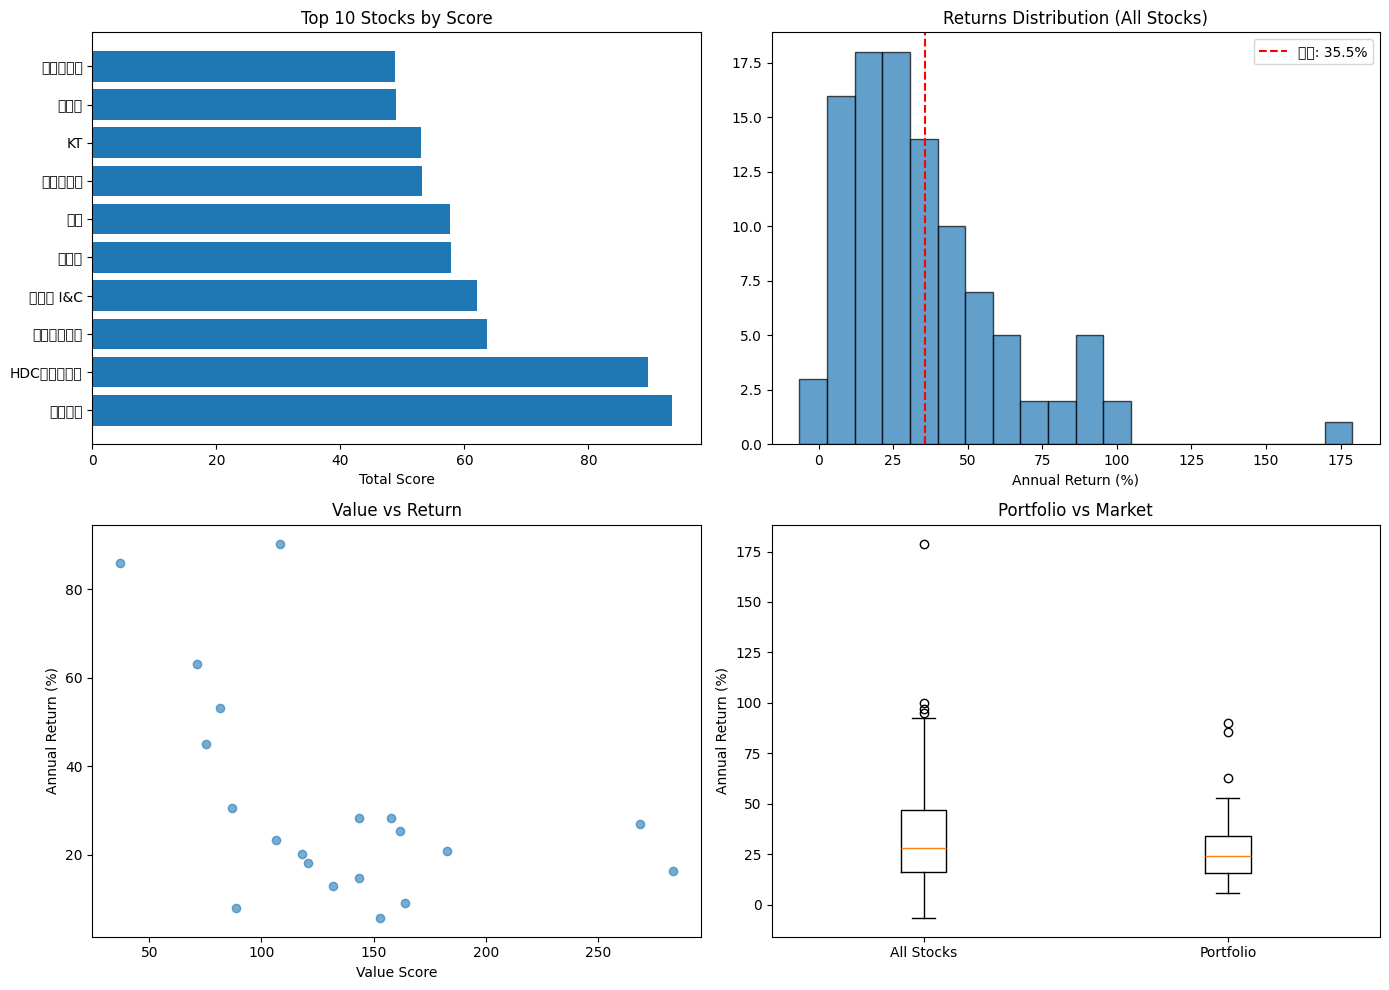


✅ 분석 완료!

💡 투자 전략 요약:
1. 상위 20개 종목으로 포트폴리오 구성
2. 동일 가중 (각 5%) 또는 시가총액 가중 선택
3. 분기별 리밸런싱 권장
4. 개별 종목 리스크 모니터링 필수


In [185]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

def load_data(file_path):
    """
    데이터 로드 및 기본 전처리
    """
    print("📂 데이터 로딩 중...")
    df = pd.read_csv(file_path, encoding='utf-8')
    
    # 날짜 컬럼 추출 (YYYYMMDD 형태)
    date_cols = [col for col in df.columns if col.isdigit() and len(col) == 8]
    
    print(f"✅ 로딩 완료: {len(df)} 행, {len(date_cols)} 거래일")
    print(f"📅 기간: {date_cols[0]} ~ {date_cols[-1]}")
    
    return df, date_cols

def get_stock_data(df, date_cols):
    """
    구분별 데이터 추출
    """
    print("\n📊 데이터 구조 파악 중...")
    
    # 구분별로 데이터 분리
    stock_data = {}
    for category in df['구분'].unique():
        stock_data[category] = df[df['구분'] == category].set_index('종목명')[date_cols]
    
    print(f"📈 구분: {list(stock_data.keys())}")
    print(f"🏢 종목 수: {len(stock_data['종가'])} 개")
    
    return stock_data

def calculate_returns(price_data, date_cols):
    """
    수익률 계산
    """
    print("\n💰 수익률 계산 중...")
    
    returns = {}
    for stock in price_data.index:
        start_price = price_data.loc[stock, date_cols[0]]
        end_price = price_data.loc[stock, date_cols[-1]]
        
        if pd.notna(start_price) and pd.notna(end_price) and start_price > 0:
            annual_return = (end_price / start_price - 1) * 100
            returns[stock] = annual_return
    
    # 기본 통계
    return_values = list(returns.values())
    print(f"📊 평균 수익률: {np.mean(return_values):.1f}%")
    print(f"📊 최고 수익률: {max(return_values):.1f}%")
    print(f"📊 최저 수익률: {min(return_values):.1f}%")
    
    return returns

def analyze_fundamentals(stock_data, date_cols):
    """
    재무지표 분석
    """
    print("\n🔍 재무지표 분석 중...")
    
    # 최신 재무지표 데이터
    fundamentals = {}
    metrics = ['PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']
    
    for metric in metrics:
        if metric in stock_data:
            latest_data = stock_data[metric][date_cols[-1]]
            fundamentals[metric] = latest_data
    
    fund_df = pd.DataFrame(fundamentals)
    
    # 각 지표의 분포 출력
    for metric in metrics:
        if metric in fund_df.columns:
            values = fund_df[metric].dropna()
            if len(values) > 0:
                print(f"{metric}: 중간값 {values.median():.1f}, 평균 {values.mean():.1f}")
    
    return fund_df

def screen_stocks(fund_df, returns):
    """
    종목 스크리닝 (실제 데이터 기반)
    """
    print("\n🎯 종목 스크리닝 중...")
    
    # 실제 데이터 분포를 고려한 현실적 기준
    criteria = {
        'PER': (0, 100),      # 0 < PER < 100
        'PBR': (0, 4),        # 0 < PBR < 4  
        'ROE': (1, 100),      # ROE > 1%
        '부채비율': (0, 150)   # 부채비율 < 150%
    }
    
    selected = []
    
    for stock in fund_df.index:
        if stock not in returns:
            continue
            
        # 모든 조건 확인
        valid = True
        for metric, (min_val, max_val) in criteria.items():
            if metric not in fund_df.columns:
                continue
                
            value = fund_df.loc[stock, metric]
            if pd.isna(value) or value <= min_val or value >= max_val:
                valid = False
                break
        
        if valid:
            selected.append(stock)
    
    print(f"✅ 선별된 종목: {len(selected)} 개")
    return selected

def calculate_scores(fund_df, returns, selected_stocks):
    """
    팩터 스코어 계산
    """
    print("\n🏆 팩터 스코어 계산 중...")
    
    scores = []
    
    for stock in selected_stocks:
        try:
            per = fund_df.loc[stock, 'PER']
            pbr = fund_df.loc[stock, 'PBR']
            roe = fund_df.loc[stock, 'ROE']
            roa = fund_df.loc[stock, 'ROA']
            profit = fund_df.loc[stock, '영업이익률']
            ret = returns[stock]
            
            # 팩터 점수 계산
            value = (1/per + 1/pbr) * 100  # 밸류 (낮을수록 좋음)
            quality = (roe + roa + profit) / 3  # 퀄리티 (높을수록 좋음)
            momentum = ret  # 모멘텀 (높을수록 좋음)
            
            # 종합 점수 (정규화 후 가중평균)
            total = value * 0.3 + quality * 0.4 + momentum * 0.3
            
            scores.append({
                '종목': stock,
                'PER': per,
                'PBR': pbr,
                'ROE': roe,
                '수익률': ret,
                'Value': value,
                'Quality': quality,
                'Momentum': momentum,
                '총점': total
            })
        except:
            continue
    
    score_df = pd.DataFrame(scores).set_index('종목')
    print(f"✅ 스코어 계산 완료: {len(score_df)} 개 종목")
    
    return score_df

def create_portfolio(score_df, top_n=20):
    """
    포트폴리오 생성
    """
    print(f"\n🎯 TOP {top_n} 포트폴리오 생성 중...")
    
    # 총점 기준 상위 종목
    top_stocks = score_df.nlargest(top_n, '총점')
    
    # 동일가중 포트폴리오
    equal_weights = {stock: 1/top_n for stock in top_stocks.index}
    
    print(f"✅ 포트폴리오 구성 완료")
    return top_stocks, equal_weights

def show_results(top_stocks, returns):
    """
    결과 출력
    """
    print("\n" + "="*60)
    print("🏆 퀀트 투자 분석 결과")
    print("="*60)
    
    print(f"\n📈 TOP 10 추천 종목:")
    for i, (stock, row) in enumerate(top_stocks.head(10).iterrows(), 1):
        print(f"{i:2d}. {stock:<15} | 총점: {row['총점']:6.1f} | 수익률: {row['수익률']:6.1f}%")
    
    # 포트폴리오 통계
    portfolio_returns = top_stocks['수익률'].values
    print(f"\n📊 포트폴리오 통계:")
    print(f"   평균 수익률: {np.mean(portfolio_returns):6.1f}%")
    print(f"   수익률 범위: {min(portfolio_returns):6.1f}% ~ {max(portfolio_returns):6.1f}%")
    print(f"   표준편차:   {np.std(portfolio_returns):6.1f}%")
    
    # 섹터/업종 분석 (종목명 기반 추정)
    print(f"\n🏭 업종 분포 (추정):")
    tech_stocks = [s for s in top_stocks.index if any(keyword in s for keyword in ['시스템', '테크', '소프트', 'IT'])]
    heavy_stocks = [s for s in top_stocks.index if any(keyword in s for keyword in ['중공업', '조선', '건설', '철강'])]
    chem_stocks = [s for s in top_stocks.index if any(keyword in s for keyword in ['화학', '케미', '제약', '바이오'])]
    
    print(f"   기술주:     {len(tech_stocks)} 개")
    print(f"   중공업:     {len(heavy_stocks)} 개") 
    print(f"   화학/바이오: {len(chem_stocks)} 개")
    print(f"   기타:       {len(top_stocks) - len(tech_stocks) - len(heavy_stocks) - len(chem_stocks)} 개")

def create_charts(top_stocks, returns):
    """
    시각화
    """
    print(f"\n📊 차트 생성 중...")
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. 상위 종목 점수
    top_10 = top_stocks.head(10)
    axes[0,0].barh(range(len(top_10)), top_10['총점'])
    axes[0,0].set_yticks(range(len(top_10)))
    axes[0,0].set_yticklabels([name[:8] for name in top_10.index])
    axes[0,0].set_title('Top 10 Stocks by Score')
    axes[0,0].set_xlabel('Total Score')
    
    # 2. 수익률 분포
    all_returns = list(returns.values())
    axes[0,1].hist(all_returns, bins=20, alpha=0.7, edgecolor='black')
    axes[0,1].axvline(np.mean(all_returns), color='red', linestyle='--', label=f'평균: {np.mean(all_returns):.1f}%')
    axes[0,1].set_title('Returns Distribution (All Stocks)')
    axes[0,1].set_xlabel('Annual Return (%)')
    axes[0,1].legend()
    
    # 3. 팩터 분석
    axes[1,0].scatter(top_stocks['Value'], top_stocks['수익률'], alpha=0.6)
    axes[1,0].set_xlabel('Value Score')
    axes[1,0].set_ylabel('Annual Return (%)')
    axes[1,0].set_title('Value vs Return')
    
    # 4. 포트폴리오 vs 전체 비교
    portfolio_returns = top_stocks['수익률'].values
    axes[1,1].boxplot([all_returns, portfolio_returns], labels=['All Stocks', 'Portfolio'])
    axes[1,1].set_title('Portfolio vs Market')
    axes[1,1].set_ylabel('Annual Return (%)')
    
    plt.tight_layout()
    plt.show()
    
    return fig

def run_analysis(file_path='analysis_df.csv'):
    """
    전체 분석 실행
    """
    print("🚀 퀀트 투자 전략 분석 시작!")
    print("="*60)
    
    # 1. 데이터 로드
    df, date_cols = load_data(file_path)
    
    # 2. 데이터 구조 파악
    stock_data = get_stock_data(df, date_cols)
    
    # 3. 수익률 계산
    returns = calculate_returns(stock_data['종가'], date_cols)
    
    # 4. 재무지표 분석
    fundamentals = analyze_fundamentals(stock_data, date_cols)
    
    # 5. 종목 스크리닝
    selected = screen_stocks(fundamentals, returns)
    
    # 6. 팩터 스코어 계산
    scores = calculate_scores(fundamentals, returns, selected)
    
    # 7. 포트폴리오 생성
    top_stocks, portfolio = create_portfolio(scores, top_n=20)
    
    # 8. 결과 출력
    show_results(top_stocks, returns)
    
    # 9. 시각화
    create_charts(top_stocks, returns)
    
    print(f"\n✅ 분석 완료!")
    
    return {
        'top_stocks': top_stocks,
        'portfolio_weights': portfolio,
        'all_scores': scores,
        'fundamentals': fundamentals
    }

# 실행
if __name__ == "__main__":
    results = run_analysis('analysis_df.csv')
    
    print(f"\n💡 투자 전략 요약:")
    print(f"1. 상위 20개 종목으로 포트폴리오 구성")
    print(f"2. 동일 가중 (각 5%) 또는 시가총액 가중 선택")
    print(f"3. 분기별 리밸런싱 권장")
    print(f"4. 개별 종목 리스크 모니터링 필수")

# =======

#### 데이터 재구조화

In [143]:
target_stock_name = analysis_df['종목명'].iloc[0]
excluded_metrics = ['PER', 'PBR']
df_stock = analysis_df[
    (analysis_df['종목명'] == target_stock_name) &
    (~analysis_df['구분'].isin(excluded_metrics))
].copy()

# 3.2. 날짜 컬럼명 추출
date_cols = [col for col in df_stock.columns if col not in ['종목명', '구분']]

# 3.3. '구분' 컬럼을 인덱스로 설정하고, 날짜 컬럼을 피벗 (전치)
df_pivot = df_stock.set_index('구분')[date_cols].T
df_pivot.columns.name = None
df_pivot.index.name = '날짜'

# 날짜 인덱스를 datetime 형식으로 변환
df_pivot.index = pd.to_datetime(df_pivot.index)

print(f"\n재구조화된 '{target_stock_name}' 데이터프레임 (PER, PBR 제외) head:")
print(df_pivot.head())
print("\ndf_pivot info:")
df_pivot.info()


재구조화된 'HD한국조선해양' 데이터프레임 (PER, PBR 제외) head:
                  종가       ROE       ROA    영업이익률      부채비율
날짜                                                         
2024-01-02  118500.0  2.614635  2.560307 -4.29154  2.121944
2024-01-03  113500.0  2.614635  2.560307 -4.29154  2.121944
2024-01-04  112000.0  2.614635  2.560307 -4.29154  2.121944
2024-01-05  110700.0  2.614635  2.560307 -4.29154  2.121944
2024-01-08  111900.0  2.614635  2.560307 -4.29154  2.121944

df_pivot info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2024-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   종가      244 non-null    float64
 1   ROE     244 non-null    float64
 2   ROA     244 non-null    float64
 3   영업이익률   244 non-null    float64
 4   부채비율    244 non-null    float64
dtypes: float64(5)
memory usage: 11.4 KB


In [144]:
print("\n결측치 처리 전 df_pivot의 결측치 개수:")
print(df_pivot.isnull().sum())

# 4.1. 모든 NaN 값을 0으로 대체
df_filled_zero = df_pivot.fillna(0)

print("\nNaN을 0으로 채운 후 df_filled_zero의 결측치 개수:")
print(df_filled_zero.isnull().sum()) # 모든 결측치가 0이 되었음을 확인할 수 있습니다.
print("\nNaN을 0으로 채운 후 df_filled_zero head:")
print(df_filled_zero.head())
print("\ndf_filled_zero info:")
df_filled_zero.info()


결측치 처리 전 df_pivot의 결측치 개수:
종가       0
ROE      0
ROA      0
영업이익률    0
부채비율     0
dtype: int64

NaN을 0으로 채운 후 df_filled_zero의 결측치 개수:
종가       0
ROE      0
ROA      0
영업이익률    0
부채비율     0
dtype: int64

NaN을 0으로 채운 후 df_filled_zero head:
                  종가       ROE       ROA    영업이익률      부채비율
날짜                                                         
2024-01-02  118500.0  2.614635  2.560307 -4.29154  2.121944
2024-01-03  113500.0  2.614635  2.560307 -4.29154  2.121944
2024-01-04  112000.0  2.614635  2.560307 -4.29154  2.121944
2024-01-05  110700.0  2.614635  2.560307 -4.29154  2.121944
2024-01-08  111900.0  2.614635  2.560307 -4.29154  2.121944

df_filled_zero info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2024-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   종가      244 non-null    float64
 1   ROE     244 non-null    float64
 2   ROA     244 non-null    float64
 3   영업이익률 


상관관계 매트릭스 (PER, PBR 제외, NaN은 0으로 처리):
             종가       ROE       ROA     영업이익률      부채비율
종가     1.000000 -0.613590 -0.612761 -0.134087 -0.087242
ROE   -0.613590  1.000000  0.999999 -0.358244  0.016170
ROA   -0.612761  0.999999  1.000000 -0.358137  0.015061
영업이익률 -0.134087 -0.358244 -0.358137  1.000000 -0.712025
부채비율  -0.087242  0.016170  0.015061 -0.712025  1.000000


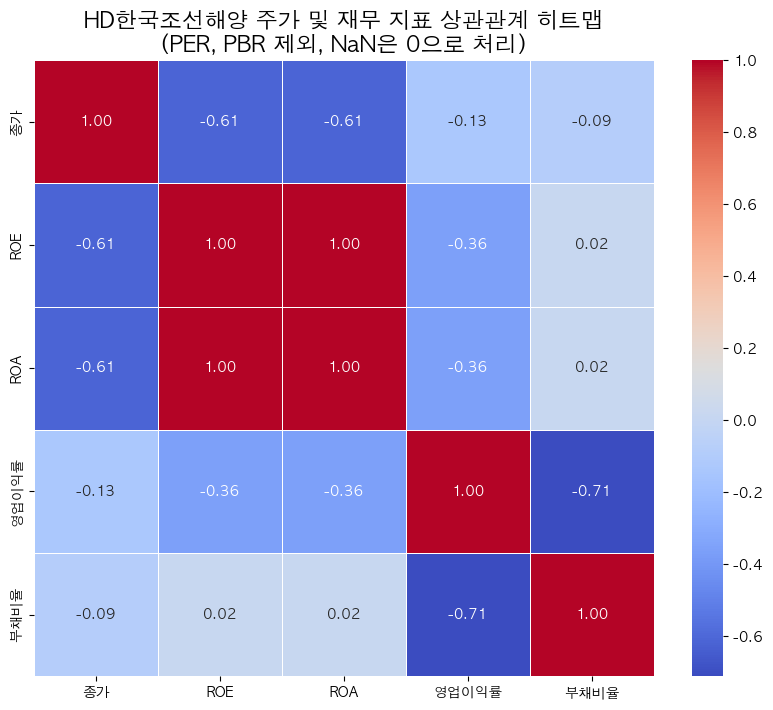

In [145]:
# 6.1. 상관관계 매트릭스 계산
# 이제 df_filled_zero를 사용합니다.
correlation_matrix = df_filled_zero.corr()

print("\n상관관계 매트릭스 (PER, PBR 제외, NaN은 0으로 처리):")
print(correlation_matrix)

# 6.2. Seaborn 히트맵 그리기
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            fmt=".2f",
            linewidths=.5)
plt.title(f'{target_stock_name} 주가 및 재무 지표 상관관계 히트맵\n(PER, PBR 제외, NaN은 0으로 처리)', fontsize=16)
plt.show()

In [174]:
# 3.1. '제이 스코 홀딩스' 종목 필터링 (PER, PBR 포함된 원본 상태로)
target_stock_name = analysis_df['종목명'].iloc[0]
# 여기서는 모든 지표를 가져옵니다. (PER, PBR 포함)
df_stock_original = analysis_df[analysis_df['종목명'] == target_stock_name].copy()

# 3.2. 날짜 컬럼명 추출
date_cols_original = [col for col in df_stock_original.columns if col not in ['종목명', '구분']]

# 3.3. '구분' 컬럼을 인덱스로 설정하고, 날짜 컬럼을 피벗 (전치)
df_pivot_original = df_stock_original.set_index('구분')[date_cols_original].T
df_pivot_original.columns.name = None
df_pivot_original.index.name = '날짜'

# 날짜 인덱스를 datetime 형식으로 변환
df_pivot_original.index = pd.to_datetime(df_pivot_original.index)

print(f"\n재구조화된 '{target_stock_name}' 데이터프레임 (모든 지표 포함) head:")
print(df_pivot_original.head())
print("\ndf_pivot_original info:")
df_pivot_original.info()

print("\n영업이익률 컬럼의 결측치 개수 (NaN 처리 전):")
print(df_pivot_original['영업이익률'].isnull().sum())
print("\n영업이익률 컬럼의 고유 값 (NaN 포함):")
print(df_pivot_original['영업이익률'].unique())


재구조화된 'HD한국조선해양' 데이터프레임 (모든 지표 포함) head:
                  종가        PER       PBR       ROE       ROA    영업이익률  \
날짜                                                                       
2024-01-02  118500.0  27.820270  0.727399  2.614635  2.560307 -4.29154   
2024-01-03  113500.0  26.646419  0.696707  2.614635  2.560307 -4.29154   
2024-01-04  112000.0  26.294264  0.687499  2.614635  2.560307 -4.29154   
2024-01-05  110700.0  25.989063  0.679519  2.614635  2.560307 -4.29154   
2024-01-08  111900.0  26.270787  0.686885  2.614635  2.560307 -4.29154   

                부채비율  
날짜                    
2024-01-02  2.121944  
2024-01-03  2.121944  
2024-01-04  2.121944  
2024-01-05  2.121944  
2024-01-08  2.121944  

df_pivot_original info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2024-01-02 to 2024-12-30
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   종가      244 non-null    float64
 1   PER     244 no

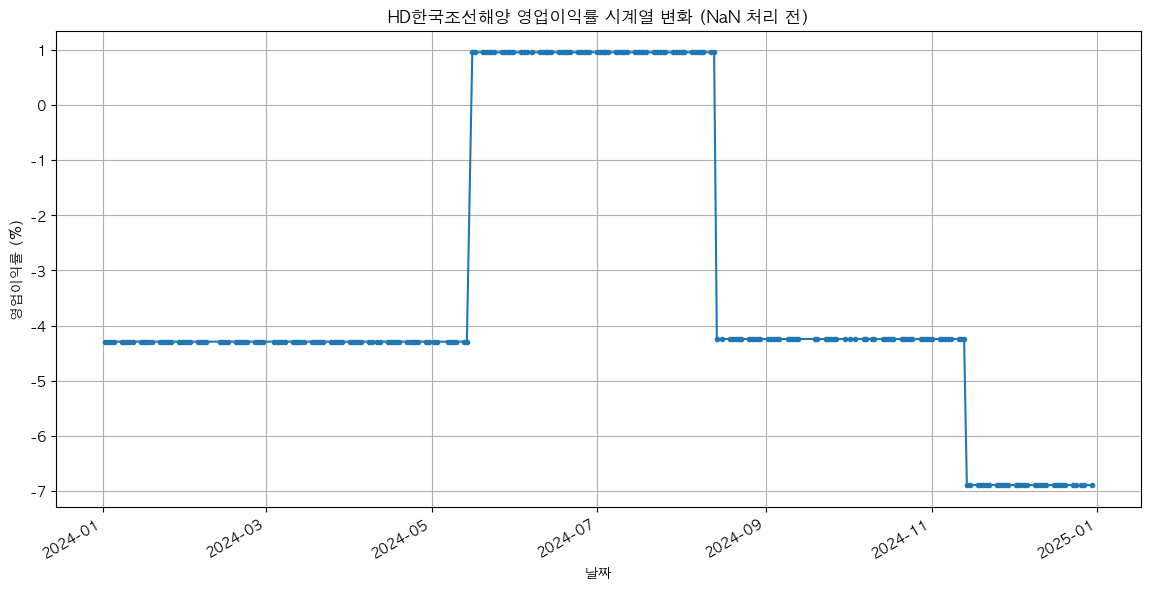

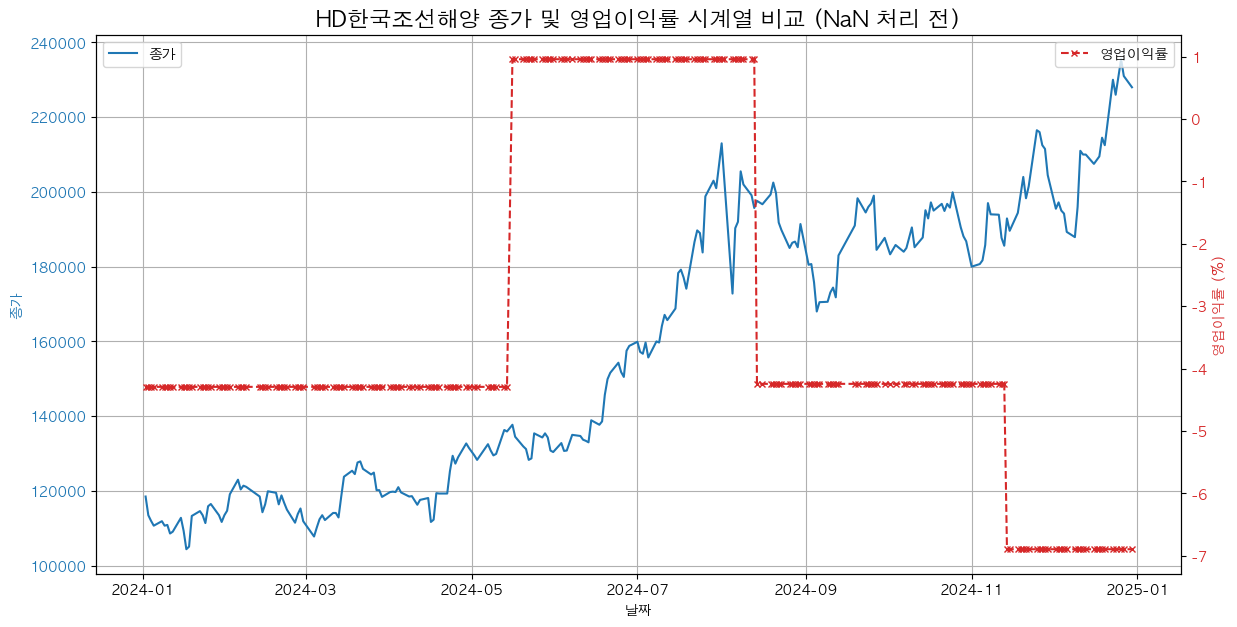

In [147]:
plt.figure(figsize=(14, 7))
# plot() 함수는 NaN 값을 자동으로 건너뛰고 그래프를 그립니다.
df_pivot_original['영업이익률'].plot(title=f'{target_stock_name} 영업이익률 시계열 변화 (NaN 처리 전)',
                                    grid=True,
                                    linestyle='-',
                                    marker='o', # 데이터 포인트 표시
                                    markersize=3)
plt.ylabel('영업이익률 (%)')
plt.xlabel('날짜')
plt.show()

# 추가적으로, 종가와 영업이익률을 함께 그려보는 것도 좋습니다.
# 종가의 스케일이 다르므로, 2개의 Y축을 사용합니다.
fig, ax1 = plt.subplots(figsize=(14, 7))

# 첫 번째 Y축: 종가
color = 'tab:blue'
ax1.set_xlabel('날짜')
ax1.set_ylabel('종가', color=color)
ax1.plot(df_pivot_original['종가'], color=color, label='종가', linestyle='-')
ax1.tick_params(axis='y', labelcolor=color)
ax1.legend(loc='upper left')
ax1.grid(True)

# 두 번째 Y축: 영업이익률
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('영업이익률 (%)', color=color)
ax2.plot(df_pivot_original['영업이익률'], color=color, label='영업이익률', linestyle='--', marker='x', markersize=4)
ax2.tick_params(axis='y', labelcolor=color)
ax2.legend(loc='upper right')

plt.title(f'{target_stock_name} 종가 및 영업이익률 시계열 비교 (NaN 처리 전)', fontsize=16)
plt.show()

In [148]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['axes.unicode_minus'] = False

In [149]:
# analysis_df가 이미 로드되어 있다고 가정합니다.
# 만약 이 셀에서 'analysis_df is not defined' 에러가 발생한다면,
# 이전 대화에서 analysis_df를 로드하는 코드를 다시 실행해주세요.
# 예: analysis_df = pd.read_csv('your_data.csv')

# --- '제이 스코 홀딩스' 데이터 재구조화 및 NaN 0 처리 과정 ---
# 이 부분은 이전 단계에서 이미 실행했지만, 코드의 연속성을 위해 다시 명시합니다.

target_stock_name = analysis_df['종목명'].iloc[0]
excluded_metrics = ['PER', 'PBR']

# '제이 스코 홀딩스' 종목 필터링 및 PER, PBR 제외
df_stock = analysis_df[
    (analysis_df['종목명'] == target_stock_name) &
    (~analysis_df['구분'].isin(excluded_metrics))
].copy()

# 날짜 컬럼명 추출
date_cols = [col for col in df_stock.columns if col not in ['종목명', '구분']]

# '구분' 컬럼을 인덱스로 설정하고, 날짜 컬럼을 피벗 (전치)
df_pivot = df_stock.set_index('구분')[date_cols].T
df_pivot.columns.name = None
df_pivot.index.name = '날짜'

# 날짜 인덱스를 datetime 형식으로 변환
df_pivot.index = pd.to_datetime(df_pivot.index)

# 모든 NaN 값을 0으로 대체
df_filled_zero = df_pivot.fillna(0)

print("\n회귀 분석에 사용될 '제이 스코 홀딩스' 데이터프레임 (df_filled_zero) head:")
print(df_filled_zero.head())
print("\ndf_filled_zero info:")
df_filled_zero.info()

# 특징(X)과 타겟(y) 분리
X = df_filled_zero[['ROE', 'ROA', '영업이익률', '부채비율']]
y = df_filled_zero['종가']

print("\nFeatures (X) head:")
print(X.head())
print("\nTarget (y) head:")
print(y.head())


회귀 분석에 사용될 '제이 스코 홀딩스' 데이터프레임 (df_filled_zero) head:
                  종가       ROE       ROA    영업이익률      부채비율
날짜                                                         
2024-01-02  118500.0  2.614635  2.560307 -4.29154  2.121944
2024-01-03  113500.0  2.614635  2.560307 -4.29154  2.121944
2024-01-04  112000.0  2.614635  2.560307 -4.29154  2.121944
2024-01-05  110700.0  2.614635  2.560307 -4.29154  2.121944
2024-01-08  111900.0  2.614635  2.560307 -4.29154  2.121944

df_filled_zero info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 244 entries, 2024-01-02 to 2024-12-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   종가      244 non-null    float64
 1   ROE     244 non-null    float64
 2   ROA     244 non-null    float64
 3   영업이익률   244 non-null    float64
 4   부채비율    244 non-null    float64
dtypes: float64(5)
memory usage: 11.4 KB

Features (X) head:
                 ROE       ROA    영업이익률      부채비율
날짜         

In [150]:
# 훈련 세트와 테스트 세트 비율 설정 (예: 80% 훈련, 20% 테스트)
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\n훈련 세트 크기: {len(X_train)} 개")
print(f"테스트 세트 크기: {len(X_test)} 개")


훈련 세트 크기: 195 개
테스트 세트 크기: 49 개


In [151]:
scaler = StandardScaler()

# 훈련 데이터에 fit_transform 적용
X_train_scaled = scaler.fit_transform(X_train)
# 테스트 데이터에 transform 적용 (훈련 데이터의 스케일링 기준 사용)
X_test_scaled = scaler.transform(X_test)

# 스케일링된 데이터를 다시 DataFrame으로 변환 (분석 용이성을 위해)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X.columns, index=X_test.index)

print("\n스케일링된 훈련 데이터 (X_train_scaled) head:")
print(X_train_scaled.head())


스케일링된 훈련 데이터 (X_train_scaled) head:
                 ROE       ROA    영업이익률      부채비율
날짜                                               
2024-01-02  0.895391  0.894436 -0.69709  1.080073
2024-01-03  0.895391  0.894436 -0.69709  1.080073
2024-01-04  0.895391  0.894436 -0.69709  1.080073
2024-01-05  0.895391  0.894436 -0.69709  1.080073
2024-01-08  0.895391  0.894436 -0.69709  1.080073


In [152]:
model = LinearRegression()

# 모델 학습
model.fit(X_train_scaled, y_train)

print("\n선형 회귀 모델 학습 완료.")


선형 회귀 모델 학습 완료.


In [153]:
# 테스트 세트에 대한 예측
y_pred = model.predict(X_test_scaled)

# 모델 성능 평가
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse) # Root Mean Squared Error
r2 = r2_score(y_test, y_pred) # R-squared

print(f"\n모델 성능 평가 (테스트 세트):")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R-squared (R2 Score): {r2:.2f}")

# 회귀 계수 확인 (각 지표의 영향력)
coefficients = pd.DataFrame({'Feature': X.columns, 'Coefficient': model.coef_})
print("\n각 지표의 회귀 계수:")
print(coefficients.sort_values(by='Coefficient', ascending=False))

# 절편 (intercept) 확인
print(f"\n모델 절편 (Intercept): {model.intercept_:.2f}")


모델 성능 평가 (테스트 세트):
Mean Squared Error (MSE): 10809807803.03
Root Mean Squared Error (RMSE): 103970.23
R-squared (R2 Score): -55.78

각 지표의 회귀 계수:
  Feature   Coefficient
1     ROA  -1217.843421
0     ROE  -1308.071656
2   영업이익률 -14296.112970
3    부채비율 -33486.287787

모델 절편 (Intercept): 146983.59


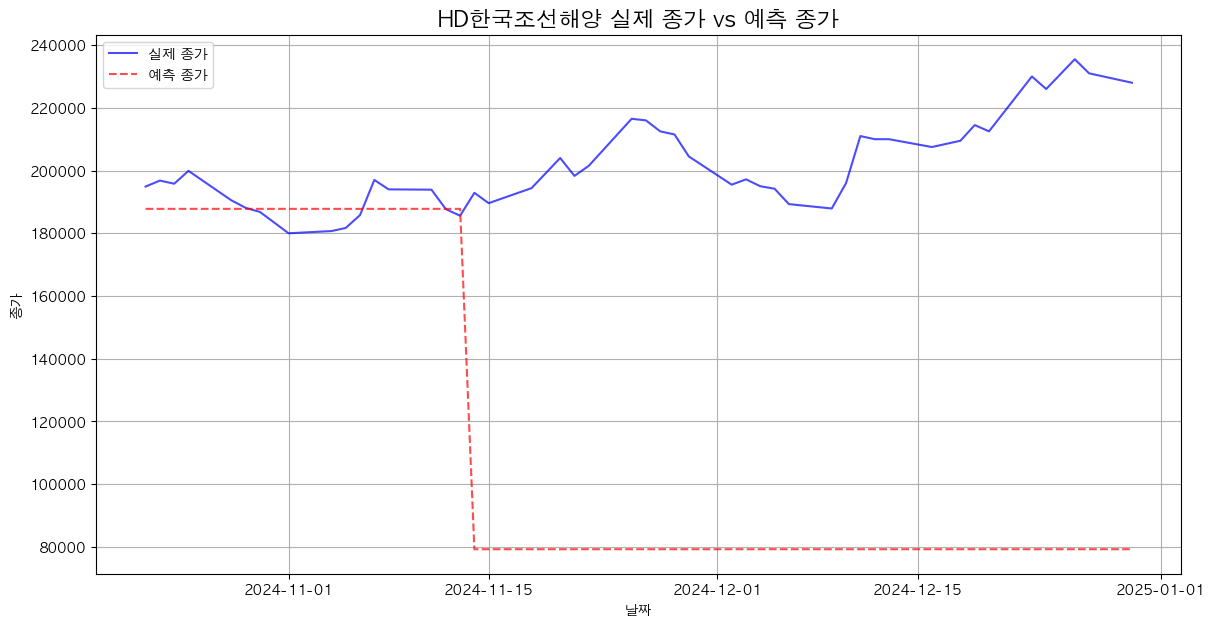

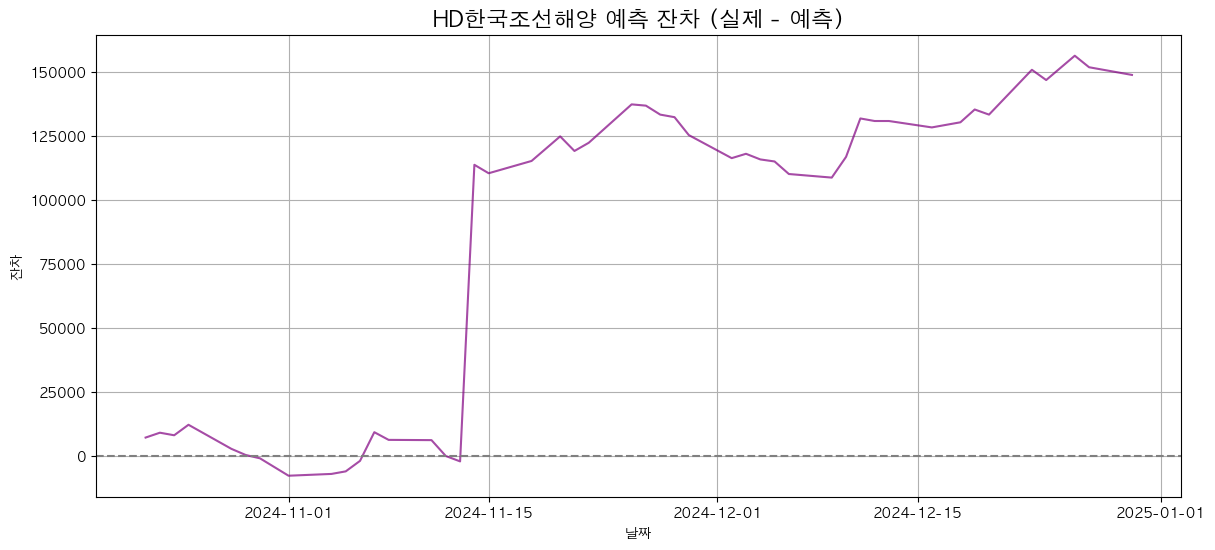

In [154]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test, label='실제 종가', color='blue', alpha=0.7)
plt.plot(y_test.index, y_pred, label='예측 종가', color='red', linestyle='--', alpha=0.7)
plt.title(f'{target_stock_name} 실제 종가 vs 예측 종가', fontsize=16)
plt.xlabel('날짜')
plt.ylabel('종가')
plt.legend()
plt.grid(True)
plt.show()

# 잔차(Residual) 분석
residuals = y_test - y_pred
plt.figure(figsize=(14, 6))
plt.plot(y_test.index, residuals, color='purple', alpha=0.7)
plt.axhline(y=0, color='gray', linestyle='--')
plt.title(f'{target_stock_name} 예측 잔차 (실제 - 예측)', fontsize=16)
plt.xlabel('날짜')
plt.ylabel('잔차')
plt.grid(True)
plt.show()

In [155]:
import pandas as pd
import numpy as np

# analysis_df가 이미 로드되어 있다고 가정합니다.
# 만약 이 셀에서 'analysis_df is not defined' 에러가 발생한다면,
# 이전 대화에서 analysis_df를 로드하는 코드를 다시 실행해주세요.
# 예: analysis_df = pd.read_csv('your_data.csv')

# --- 1. analysis_df의 날짜 컬럼을 모두 찾기 ---
# '종목명'과 '구분'을 제외한 모든 컬럼이 날짜 컬럼입니다.
date_cols = [col for col in analysis_df.columns if col not in ['종목명', '구분']]

# --- 2. Long Format으로 변환 (stack) ---
# 모든 날짜 컬럼을 하나의 '날짜' 컬럼으로 쌓아 올립니다.
df_long = analysis_df.set_index(['종목명', '구분'])[date_cols].stack().reset_index()
df_long.columns = ['종목명', '구분', '날짜', '값'] # 컬럼명 변경

# '날짜' 컬럼을 datetime 형식으로 변환
df_long['날짜'] = pd.to_datetime(df_long['날짜'])

print("Long Format으로 변환된 데이터 (df_long) head:")
print(df_long.head())
print("\ndf_long info:")
df_long.info()

# --- 3. Wide Format으로 변환 (unstack/pivot) ---
# '구분' 컬럼의 값(종가, PER 등)을 새로운 컬럼으로 만듭니다.
# '날짜'와 '종목명'을 기준으로 피벗합니다.
df_wide = df_long.pivot_table(index=['날짜', '종목명'], columns='구분', values='값')

# 컬럼명 정리
df_wide = df_wide.reset_index()
df_wide.columns.name = None # 컬럼명 인덱스 이름 제거

# 데이터프레임 컬럼 순서 조정 (보기 좋게)
# 모든 지표가 다 있을 경우의 컬럼 순서 지정
all_metrics = ['종가', 'PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율']
# 실제 df_wide에 있는 컬럼만 사용하여 순서 조정
ordered_cols = ['날짜', '종목명'] + [metric for metric in all_metrics if metric in df_wide.columns]
df_wide = df_wide[ordered_cols]

print("\nWide Format으로 재구조화된 데이터 (df_wide) head:")
print(df_wide.head())
print("\ndf_wide info:")
df_wide.info()

# --- 4. PER, PBR 컬럼 제외 및 NaN 0 처리 ---
# 이제 모든 종목에 대해 일괄적으로 적용합니다.
# 제외할 지표 리스트
metrics_to_exclude = ['PER', 'PBR']

# 해당 지표 컬럼이 존재하면 제외
for metric in metrics_to_exclude:
    if metric in df_wide.columns:
        df_wide = df_wide.drop(columns=[metric])
        print(f"'{metric}' 컬럼이 제거되었습니다.")

# 나머지 모든 숫자 컬럼에 대해 NaN 값을 0으로 채웁니다.
# '날짜'와 '종목명' 컬럼은 제외하고 숫자형 컬럼에만 적용
numeric_cols = df_wide.select_dtypes(include=np.number).columns
df_final = df_wide.copy() # 원본 보존을 위해 복사본 생성
df_final[numeric_cols] = df_final[numeric_cols].fillna(0)

print("\nPER, PBR 제외 및 NaN 0 처리 후 최종 데이터 (df_final) head:")
print(df_final.head())
print("\ndf_final info:")
df_final.info()
print("\ndf_final의 결측치 확인:")
print(df_final.isnull().sum())
df_final

Long Format으로 변환된 데이터 (df_long) head:
        종목명  구분         날짜         값
0  HD한국조선해양  종가 2024-01-02  118500.0
1  HD한국조선해양  종가 2024-01-03  113500.0
2  HD한국조선해양  종가 2024-01-04  112000.0
3  HD한국조선해양  종가 2024-01-05  110700.0
4  HD한국조선해양  종가 2024-01-08  111900.0

df_long info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168332 entries, 0 to 168331
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   종목명     168332 non-null  object        
 1   구분      168332 non-null  object        
 2   날짜      168332 non-null  datetime64[ns]
 3   값       168332 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 5.1+ MB

Wide Format으로 재구조화된 데이터 (df_wide) head:
          날짜        종목명        종가        PER       PBR        ROE       ROA  \
0 2024-01-02       GS건설   14730.0        NaN  0.298954 -13.775571 -4.343823   
1 2024-01-02  HDC현대산업개발   14210.0   5.444813  0.303897   5.581413  2.541921

,날짜,종목명,종가,ROE,ROA,영업이익률,부채비율
0,2024-01-02,GS건설,14730.0,-13.775571,-4.343823,-7.564895,217.130152
1,2024-01-02,HDC현대산업개발,14210.0,5.581413,2.541921,4.548237,119.574583
2,2024-01-02,HD한국조선해양,118500.0,2.614635,2.560307,-4.291540,2.121944
3,2024-01-02,HD현대,62600.0,13.037357,8.474707,83.628112,53.838434
4,2024-01-02,HJ중공업,4040.0,-33.242240,-3.933024,-5.007713,745.208240
...,...,...,...,...,...,...,...
25127,2024-12-30,화승인더,4450.0,2.673919,1.372287,2.218714,94.851288
25128,2024-12-30,휴니드,7710.0,3.304813,2.132344,6.741814,54.984981
25129,2024-12-30,휴림에이텍,564.0,-0.751278,-0.631506,3.638788,18.966073
25130,2024-12-30,휴메딕스,42250.0,4.197535,3.859098,24.748460,8.769847


In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.rcParams['axes.unicode_minus'] = False

In [157]:
# df_final 데이터프레임이 이미 메모리에 있다고 가정합니다.
# 만약 이 셀에서 'df_final is not defined' 에러가 발생한다면,
# 이전 대화에서 df_final을 생성하는 코드를 다시 실행해주세요.
# (단계 1: 데이터 재구조화 부분)
print("종목별 상관관계 분석을 위한 df_final head:")
print(df_final.head())
print("\ndf_final info:")
df_final.info()

종목별 상관관계 분석을 위한 df_final head:
          날짜        종목명        종가        ROE       ROA      영업이익률        부채비율
0 2024-01-02       GS건설   14730.0 -13.775571 -4.343823  -7.564895  217.130152
1 2024-01-02  HDC현대산업개발   14210.0   5.581413  2.541921   4.548237  119.574583
2 2024-01-02   HD한국조선해양  118500.0   2.614635  2.560307  -4.291540    2.121944
3 2024-01-02       HD현대   62600.0  13.037357  8.474707  83.628112   53.838434
4 2024-01-02      HJ중공업    4040.0 -33.242240 -3.933024  -5.007713  745.208240

df_final info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25132 entries, 0 to 25131
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      25132 non-null  datetime64[ns]
 1   종목명     25132 non-null  object        
 2   종가      25132 non-null  float64       
 3   ROE     25132 non-null  float64       
 4   ROA     25132 non-null  float64       
 5   영업이익률   25132 non-null  float64       
 6   부채비율    25132 non-nu

In [158]:
all_stocks = df_final['종목명'].unique()
print(f"\n분석할 총 종목 수: {len(all_stocks)}")
print(f"분석할 종목 리스트: {all_stocks[:5]} ... (일부만 표시)") # 너무 많으면 일부만 출력


분석할 총 종목 수: 103
분석할 종목 리스트: ['GS건설' 'HDC현대산업개발' 'HD한국조선해양' 'HD현대' 'HJ중공업'] ... (일부만 표시)



모든 종목의 '종가'와 재무 지표 간 상관관계 요약 (df_correlations):
                ROE       ROA     영업이익률      부채비율
종목명                                              
GS건설       0.447839  0.455469  0.649361 -0.603106
HDC현대산업개발 -0.482019 -0.499811  0.612235  0.507965
HD한국조선해양  -0.613590 -0.612761 -0.134087 -0.087242
HD현대      -0.614113 -0.620203 -0.522240 -0.462331
HJ중공업      0.338858  0.366839  0.557554 -0.621225

총 103개 종목의 상관관계가 계산되었습니다.


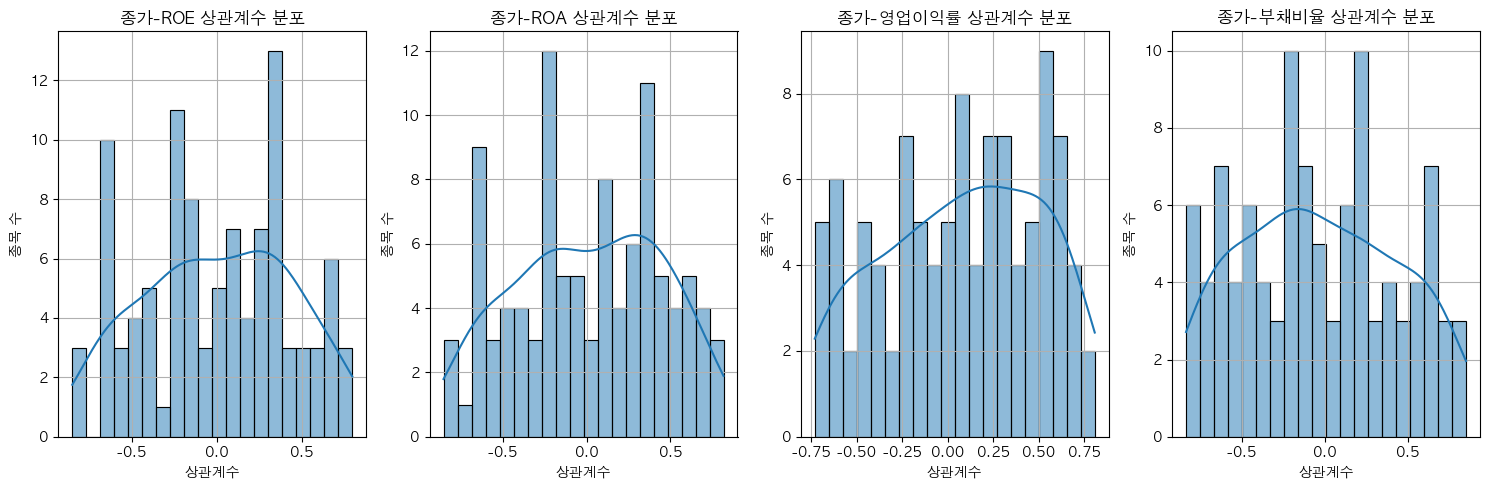

In [159]:
# 상관관계 결과를 저장할 딕셔너리
correlation_results = {}

# 분석할 지표들 (종가를 제외한 특징 지표)
features = ['ROE', 'ROA', '영업이익률', '부채비율']
target = '종가'

# 각 종목별로 반복
for stock_name in all_stocks:
    # 해당 종목의 데이터만 필터링
    df_stock = df_final[df_final['종목명'] == stock_name].copy()

    # 상관관계 계산을 위한 숫자형 컬럼만 선택
    # 종가와 특징 지표가 모두 있는지 확인 (결측치 처리 후 데이터가 부족할 수 있음)
    cols_for_corr = [target] + [f for f in features if f in df_stock.columns]

    if len(df_stock) > 1 and all(col in df_stock.columns for col in cols_for_corr): # 데이터가 최소 2개 이상이고 필요한 컬럼이 있는지 확인
        # 상관관계 매트릭스 계산
        corr_matrix = df_stock[cols_for_corr].corr()

        # '종가'와 각 지표 간의 상관계수만 추출
        if target in corr_matrix.index and len(corr_matrix.columns) > 1:
            stock_corr = corr_matrix.loc[target, features].to_dict()
            correlation_results[stock_name] = stock_corr
        else:
            print(f"주의: '{stock_name}' 종목은 상관관계를 계산하기에 충분한 데이터가 없거나, '종가' 컬럼이 없습니다. 건너뜁니다.")
    else:
        print(f"주의: '{stock_name}' 종목은 데이터 포인트가 부족하여 상관관계를 계산할 수 없습니다. (데이터 수: {len(df_stock)})")

# 결과를 DataFrame으로 변환하여 보기 쉽게 만듭니다.
df_correlations = pd.DataFrame.from_dict(correlation_results, orient='index')
df_correlations.index.name = '종목명'

print("\n모든 종목의 '종가'와 재무 지표 간 상관관계 요약 (df_correlations):")
print(df_correlations.head())
print(f"\n총 {len(df_correlations)}개 종목의 상관관계가 계산되었습니다.")

# 각 상관관계 분포를 시각화하여 대략적인 경향 파악 (선택 사항)
plt.figure(figsize=(15, 5))
for i, feature in enumerate(features):
    plt.subplot(1, len(features), i + 1)
    sns.histplot(df_correlations[feature].dropna(), bins=20, kde=True)
    plt.title(f'종가-{feature} 상관계수 분포')
    plt.xlabel('상관계수')
    plt.ylabel('종목 수')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [160]:
# 신뢰 종목을 추출할 기준 정의
# 여기서는 예시로 'ROE'와 '종가'의 상관계수가 특정 값 이상인 경우를 기준으로 합니다.
# 여러 지표를 조합하여 복합적인 기준을 만들 수도 있습니다.

# 예시 기준: 종가와 ROE 간의 상관계수가 0.3 이상인 종목
# (0.3은 임의의 값이며, 실제 분석에서 조정 필요)
threshold_roe_corr = 0.3
reliable_stocks_roe = df_correlations[
    (df_correlations['ROE'].abs() >= threshold_roe_corr) & # 상관계수 절대값이 임계값 이상
    (df_correlations['ROE'] > 0) # 양의 상관관계만 고려할 경우
].copy()

# 예시 기준: 종가와 영업이익률 간의 상관계수가 -0.4 이하인 종목 (음의 상관관계가 강한 종목)
threshold_op_profit_corr = -0.4
reliable_stocks_op_profit = df_correlations[
    (df_correlations['영업이익률'].abs() >= abs(threshold_op_profit_corr)) &
    (df_correlations['영업이익률'] < 0) # 음의 상관관계만 고려할 경우
].copy()

# 모든 기준을 만족하는 종목 (AND 조건)
# 예: ROE 상관계수 0.3 이상 AND 부채비율 상관계수 -0.2 이하인 종목
threshold_debt_ratio_corr = -0.2
highly_reliable_stocks = df_correlations[
    (df_correlations['ROE'] >= threshold_roe_corr) &
    (df_correlations['부채비율'] <= threshold_debt_ratio_corr)
].copy()


print(f"\n신뢰도 기준 1 (종가-ROE 상관계수 >= {threshold_roe_corr}) 만족 종목:")
print(reliable_stocks_roe)
print(f"\n신뢰도 기준 2 (종가-영업이익률 상관계수 <= {threshold_op_profit_corr}) 만족 종목:")
print(reliable_stocks_op_profit)
print(f"\n신뢰도 기준 3 (종가-ROE 상관계수 >= {threshold_roe_corr} AND 종가-부채비율 상관계수 <= {threshold_debt_ratio_corr}) 만족 종목:")
print(highly_reliable_stocks)

# 각 종목의 상관관계 값들을 한눈에 보기 쉽게 저장 (CSV 등으로 저장 가능)
# df_correlations.to_csv('stock_correlations.csv')


신뢰도 기준 1 (종가-ROE 상관계수 >= 0.3) 만족 종목:
               ROE       ROA     영업이익률      부채비율
종목명                                             
GS건설      0.447839  0.455469  0.649361 -0.603106
HJ중공업     0.338858  0.366839  0.557554 -0.621225
SK하이닉스    0.616748  0.609269  0.471991 -0.119083
STX엔진     0.607016  0.600713  0.646971  0.538678
광무        0.670297  0.667862  0.103641 -0.686112
국영지앤엠     0.564860  0.566490  0.548915 -0.212509
대명소노시즌    0.660895  0.659605  0.650085 -0.382312
두산에너빌리티   0.651278  0.652107 -0.673300 -0.103622
라이콤       0.738837  0.740813 -0.642395  0.766346
레인보우로보틱스  0.369124  0.367357 -0.624874 -0.815832
삼성중공업     0.314937  0.319061  0.202344 -0.758265
삼일제약      0.681199  0.646703 -0.102305 -0.580401
서진시스템     0.404382  0.399696 -0.668537 -0.164707
신성델타테크    0.334316  0.344275  0.551349 -0.731058
신세계 I&C   0.472516  0.457290  0.043751  0.645923
아이비김영     0.381304  0.390576  0.330771 -0.442235
유니퀘스트     0.793445  0.816361 -0.003147 -0.377816
유엔젤       0.364437  0.368279  0

In [161]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression # 회귀 모델
from sklearn.preprocessing import StandardScaler # 스케일링
import matplotlib.pyplot as plt
import seaborn as sns

In [162]:
# df_final 데이터프레임이 이미 메모리에 있다고 가정합니다.
# 이전 단계에서 생성된 df_final이 없다면, '단계 1: 데이터 재구조화' 코드를 다시 실행해주세요.
print("계수 분석을 위한 df_final head:")
print(df_final.head())
print("\ndf_final info:")
df_final.info()

계수 분석을 위한 df_final head:
          날짜        종목명        종가        ROE       ROA      영업이익률        부채비율
0 2024-01-02       GS건설   14730.0 -13.775571 -4.343823  -7.564895  217.130152
1 2024-01-02  HDC현대산업개발   14210.0   5.581413  2.541921   4.548237  119.574583
2 2024-01-02   HD한국조선해양  118500.0   2.614635  2.560307  -4.291540    2.121944
3 2024-01-02       HD현대   62600.0  13.037357  8.474707  83.628112   53.838434
4 2024-01-02      HJ중공업    4040.0 -33.242240 -3.933024  -5.007713  745.208240

df_final info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25132 entries, 0 to 25131
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   날짜      25132 non-null  datetime64[ns]
 1   종목명     25132 non-null  object        
 2   종가      25132 non-null  float64       
 3   ROE     25132 non-null  float64       
 4   ROA     25132 non-null  float64       
 5   영업이익률   25132 non-null  float64       
 6   부채비율    25132 non-null  fl

In [163]:
# 계수 결과를 저장할 딕셔너리
coefficient_results = {}

# 분석할 특징 지표들
features = ['ROE', 'ROA', '영업이익률', '부채비율']
target = '종가'

# 모든 고유 종목명 가져오기
all_stocks = df_final['종목명'].unique()

# 각 종목별로 반복
for stock_name in all_stocks:
    # 해당 종목의 데이터만 필터링
    df_stock = df_final[df_final['종목명'] == stock_name].copy()

    # 종속변수(y)와 독립변수(X) 설정
    X = df_stock[features]
    y = df_stock[target]

    # 결측치 확인 및 처리 (NaN은 이미 0으로 처리되어 있으므로 추가적인 NaN 없음)
    # 하지만 특정 컬럼의 값이 모두 같거나 데이터가 부족하면 모델 학습 불가
    # 최소한 독립변수 개수 + 1 만큼의 데이터 포인트가 있어야 함
    if len(X) <= len(features):
        print(f"경고: '{stock_name}' 종목은 데이터 포인트({len(X)}개)가 너무 적어 계수 분석을 건너_입니다.")
        continue

    # 독립변수들 중 분산이 0인 (모든 값이 동일한) 컬럼 확인 및 제거 (스케일링 시 에러 발생 방지)
    # 예를 들어 ROE, ROA 등 재무 지표는 특정 기간 동안 값이 동일하게 유지되는 경우가 많습니다.
    # 이런 컬럼은 회귀 분석에 유의미하지 않으므로 제거하거나 처리해야 합니다.
    # 여기서는 모두 동일한 값을 가지는 컬럼을 제거합니다.
    # 하지만, 재무 지표가 분기/연 업데이트이므로 값이 같을 수 있습니다.
    # 이 경우 해당 컬럼을 제거하지 않고 스케일링 시에 `with_std=False` 옵션을 주거나,
    # 아니면 해당 종목의 계수 분석을 건너뛰는 방법을 사용해야 합니다.
    # 여기서는 모든 값이 동일한 컬럼은 스케일링에서 제외하고 계수도 0으로 처리하는 방식으로 진행합니다.

    # 스케일링을 위한 유효한 컬럼만 선택
    valid_features = []
    for col in features:
        if X[col].nunique() > 1: # 고유한 값이 1개보다 많아야 (즉, 모든 값이 동일하지 않아야) 분산을 가짐
            valid_features.append(col)
        else:
            print(f"정보: '{stock_name}' 종목의 '{col}' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.")

    if not valid_features:
        print(f"경고: '{stock_name}' 종목은 분석 가능한 독립 변수가 없어 계수 분석을 건너뜁니다.")
        continue

    X_valid = X[valid_features]

    # 데이터 스케일링 (StandardScaler 사용)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_valid)

    # 스케일링된 데이터를 DataFrame으로 변환 (컬럼명 유지를 위해)
    X_scaled_df = pd.DataFrame(X_scaled, columns=valid_features, index=X.index)

    # 선형 회귀 모델 학습
    model = LinearRegression()
    model.fit(X_scaled_df, y)

    # 계수 추출
    stock_coefficients = model.coef_
    intercept = model.intercept_

    # 결과를 딕셔너리에 저장
    coefficients = {feature: coef for feature, coef in zip(valid_features, stock_coefficients)}
    coefficients['_Intercept'] = intercept # 절편도 함께 저장
    coefficient_results[stock_name] = coefficients

# 결과를 DataFrame으로 변환하여 보기 쉽게 만듭니다.
df_coefficients = pd.DataFrame.from_dict(coefficient_results, orient='index')
df_coefficients.index.name = '종목명'

print("\n모든 종목의 회귀 계수 (df_coefficients) head:")
print(df_coefficients.head())
print(f"\n총 {len(df_coefficients)}개 종목의 계수가 분석되었습니다.")

정보: '미래에셋증권' 종목의 'ROE' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '미래에셋증권' 종목의 'ROA' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '미래에셋증권' 종목의 '영업이익률' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
정보: '미래에셋증권' 종목의 '부채비율' 컬럼은 모든 값이 동일하여 계수 분석에서 제외됩니다.
경고: '미래에셋증권' 종목은 분석 가능한 독립 변수가 없어 계수 분석을 건너뜁니다.

모든 종목의 회귀 계수 (df_coefficients) head:
                    ROE           ROA         영업이익률          부채비율  \
종목명                                                                 
GS건설       -1968.164953  -2000.050288   5178.538634    428.474960   
HDC현대산업개발   -139.513037   -214.720813   1507.412377   1101.589760   
HD한국조선해양  -18275.857861 -18116.839044 -40208.435137 -31259.259993   
HD현대       -7193.405046  -8114.663897  -1946.322736  13686.307199   
HJ중공업       -295.940932   -391.410382    851.301536   -182.838085   

              _Intercept  
종목명                       
GS건설        16744.262295  
HDC현대산업개발   19247.090164  
HD한국조선해양   157845.901639  
HD현대        73563.114754  
HJ중공업        3329.385246  

총 102개 종목의 계수가 분석되었습니다.


In [167]:
df_coefficients.to_csv('df_coefficients.csv', encoding='utf-8-sig')

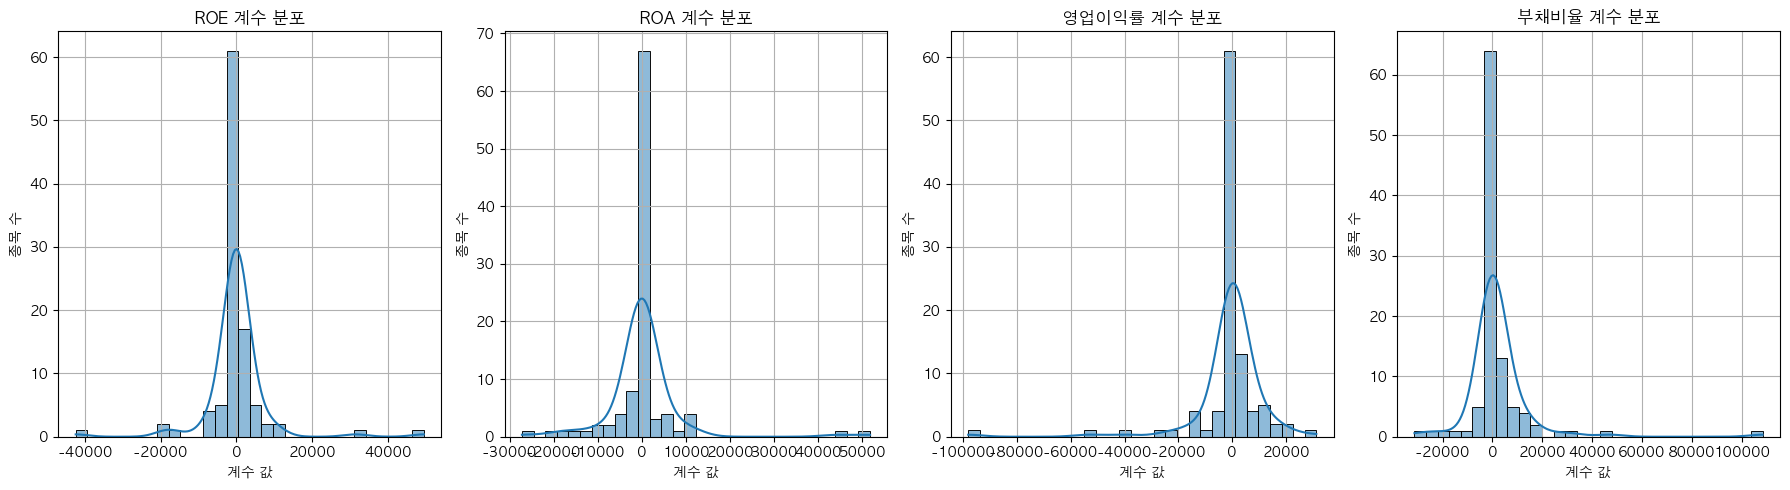


각 지표별 회귀 계수의 평균 및 표준편차:
              ROE          ROA         영업이익률          부채비율
mean    22.654054   184.201797  -1029.906858   2425.118555
std   8382.932871  8702.487748  13879.785228  13899.943305

ROE 계수가 높은 상위 10개 종목:
                   ROE           ROA         영업이익률           부채비율  \
종목명                                                                 
SK하이닉스    49618.465766  43996.073742 -98122.370624  -24942.584229   
엔켐        31544.817477  51741.130109  11451.503559  108397.194218   
자람테크놀로지   10407.463668   9632.875986 -21958.584699    3546.285514   
현대차       10280.423253  10365.263892   5954.637839   -5533.558045   
제이앤티씨      9201.160929  12096.966010 -12520.297743   -9632.714044   
레인보우로보틱스   7950.930703  10701.775867 -25126.851016   11997.894720   
STX엔진      6370.467563   6002.828179 -11979.362572    5701.364185   
에이비엘바이오    6200.484256   7863.194664 -15785.858552    9477.049841   
유한양행       6196.929350   5563.154408  18876.844871   31980.758965   
한미반도체      5097.

In [164]:
# 계수들의 분포를 시각화 (히스토그램)
plt.figure(figsize=(18, 5)) # 그래프 크기 조정

for i, feature in enumerate(features):
    if feature in df_coefficients.columns: # 해당 특징의 계수 컬럼이 존재하는 경우에만
        plt.subplot(1, len(features), i + 1)
        sns.histplot(df_coefficients[feature].dropna(), bins=30, kde=True)
        plt.title(f'{feature} 계수 분포', fontsize=12)
        plt.xlabel('계수 값')
        plt.ylabel('종목 수')
        plt.grid(True)
    else:
        # 해당 특징의 계수 컬럼이 아예 없는 경우 (예: 모든 종목에서 해당 컬럼의 값이 동일했거나)
        plt.subplot(1, len(features), i + 1)
        plt.title(f'{feature} 계수 분포 (데이터 부족)', fontsize=12)
        plt.text(0.5, 0.5, '계수 데이터 없음', horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
        plt.grid(True)


plt.tight_layout()
plt.show()

# 각 지표별 계수의 평균 및 표준편차 확인
print("\n각 지표별 회귀 계수의 평균 및 표준편차:")
print(df_coefficients[features].describe().loc[['mean', 'std']])

# 특정 기준에 따라 계수 값 확인 (예시: ROE 계수가 높은 상위 10개 종목)
print("\nROE 계수가 높은 상위 10개 종목:")
print(df_coefficients.sort_values(by='ROE', ascending=False).head(10))

print("\n영업이익률 계수가 낮은 (음의 영향력이 큰) 하위 10개 종목:")
print(df_coefficients.sort_values(by='영업이익률', ascending=True).head(10))

In [306]:
analysis_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 938 entries, 0 to 937
Columns: 246 entries, 종목명 to 20241230
dtypes: float64(244), object(2)
memory usage: 1.8+ MB


In [304]:
analysis_df['구분'].unique()

array(['종가', 'PER', 'PBR', 'ROE', 'ROA', '영업이익률', '부채비율'], dtype=object)

In [168]:
analysis_df

,종목명,구분,20240102,20240103,20240104,20240105,20240108,20240109,20240110,20240111,...,20241216,20241217,20241218,20241219,20241220,20241223,20241224,20241226,20241227,20241230
0,HD한국조선해양,종가,118500.000000,113500.000000,112000.000000,110700.000000,111900.000000,110700.000000,110900.000000,108600.000000,...,207500.000000,208500.000000,209500.000000,214500.000000,212500.000000,230000.000000,226000.000000,235500.000000,231000.000000,228000.000000
1,HD한국조선해양,PER,27.820270,26.646419,26.294264,25.989063,26.270787,25.989063,26.036017,25.496045,...,1638.942580,1646.841098,1654.739617,1694.232209,1678.435172,1816.659245,1785.065171,1860.101097,1824.557764,1800.862208
2,HD한국조선해양,PBR,0.727399,0.696707,0.687499,0.679519,0.686885,0.679519,0.680747,0.666629,...,1.260073,1.266146,1.272219,1.302582,1.290437,1.396708,1.372417,1.430107,1.402780,1.384563
3,HD한국조선해양,ROE,2.614635,2.614635,2.614635,2.614635,2.614635,2.614635,2.614635,2.614635,...,0.076883,0.076883,0.076883,0.076883,0.076883,0.076883,0.076883,0.076883,0.076883,0.076883
4,HD한국조선해양,ROA,2.560307,2.560307,2.560307,2.560307,2.560307,2.560307,2.560307,2.560307,...,0.075148,0.075148,0.075148,0.075148,0.075148,0.075148,0.075148,0.075148,0.075148,0.075148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
716,금호전기,PBR,8.791947,8.760169,8.728391,8.791947,8.728391,8.728391,8.760169,8.728391,...,8.606987,8.585496,8.488788,8.499534,8.574751,8.714440,8.585496,8.692949,9.638536,10.100584
717,금호전기,ROE,-297.906540,-297.906540,-297.906540,-297.906540,-297.906540,-297.906540,-297.906540,-297.906540,...,-18.219323,-18.219323,-18.219323,-18.219323,-18.219323,-18.219323,-18.219323,-18.219323,-18.219323,-18.219323
718,금호전기,ROA,-36.354011,-36.354011,-36.354011,-36.354011,-36.354011,-36.354011,-36.354011,-36.354011,...,-2.717013,-2.717013,-2.717013,-2.717013,-2.717013,-2.717013,-2.717013,-2.717013,-2.717013,-2.717013
719,금호전기,영업이익률,-10.157383,-10.157383,-10.157383,-10.157383,-10.157383,-10.157383,-10.157383,-10.157383,...,-7.314557,-7.314557,-7.314557,-7.314557,-7.314557,-7.314557,-7.314557,-7.314557,-7.314557,-7.314557


# =================================================================

In [300]:
def meaningful_correlation_analysis(analysis_df):
    """의미있는 상관관계 분석 (PER, PBR 제외)"""
    
    results = []
    companies = analysis_df['종목명'].unique()
    
    for company in companies:
        try:
            company_data = analysis_df[analysis_df['종목명'] == company]
            
            # 구분별로 딕셔너리 만들기
            metrics_dict = {}
            for _, row in company_data.iterrows():
                metric = row['구분']
                values = []
                for col in row.index[2:]:
                    if pd.notna(row[col]):
                        values.append(float(row[col]))
                
                if len(values) > 0:
                    metrics_dict[metric] = values
            
            if '종가' in metrics_dict and len(metrics_dict) > 1:
                stock_prices = metrics_dict['종가']
                correlations = {'종목명': company, '데이터수': len(stock_prices)}
                
                # PER, PBR 제외하고 분석
                exclude_metrics = ['종가', 'PER', 'PBR']
                
                for metric, values in metrics_dict.items():
                    if (metric not in exclude_metrics and 
                        len(values) == len(stock_prices)):
                        
                        # 값이 모두 같으면 스킵 (상수 체크)
                        if len(set(values)) > 1:  # 서로 다른 값이 있을 때만
                            corr = pd.Series(stock_prices).corr(pd.Series(values))
                            correlations[metric] = corr
                        else:
                            correlations[metric] = 0.0  # 상수면 상관관계 0
                
                results.append(correlations)
                
        except Exception as e:
            continue
    
    return pd.DataFrame(results)

# 실행
meaningful_results = meaningful_correlation_analysis(analysis_df)
print(meaningful_results.head())

       종목명  데이터수       ROE       ROA     영업이익률      부채비율
0  제이스코홀딩스   244  0.270580  0.253226 -0.440476 -0.202563
1   퀀타매트릭스   244  0.377161  0.514529 -0.156500  0.381488
2     삼익악기   244  0.131611  0.126966  0.027908  0.461236
3     나노엔텍   244 -0.176444 -0.176193 -0.270843 -0.013277
4       동방   244  0.439246  0.454988 -0.250219 -0.413954


In [301]:
meaningful_results

,종목명,데이터수,ROE,ROA,영업이익률,부채비율
0,제이스코홀딩스,244,0.270580,0.253226,-0.440476,-0.202563
1,퀀타매트릭스,244,0.377161,0.514529,-0.156500,0.381488
2,삼익악기,244,0.131611,0.126966,0.027908,0.461236
3,나노엔텍,244,-0.176444,-0.176193,-0.270843,-0.013277
4,동방,244,0.439246,0.454988,-0.250219,-0.413954
...,...,...,...,...,...,...
129,HDC현대산업개발,244,-0.482019,-0.499811,0.612235,0.507965
130,HLB생명과학,244,0.000000,0.000000,-0.089372,0.731293
131,한국콜마,244,0.900728,0.894434,0.556081,0.308976
132,에스디바이오센서,244,-0.475579,-0.475409,NaN,0.387196


In [307]:
analysis_df

,종목명,구분,20240102,20240103,20240104,20240105,20240108,20240109,20240110,20240111,...,20241216,20241217,20241218,20241219,20241220,20241223,20241224,20241226,20241227,20241230
0,제이스코홀딩스,종가,1430.000000,1477.000000,1408.000000,1401.000000,1414.000000,1425.000000,1460.000000,1469.000000,...,1854.000000,1871.000000,1825.000000,1847.000000,1744.000000,1725.000000,1739.000000,1702.000000,1626.000000,1693.000000
1,제이스코홀딩스,PER,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,제이스코홀딩스,PBR,1.400996,1.447042,1.379442,1.372584,1.385320,1.396097,1.430387,1.439205,...,1.777508,1.793806,1.749704,1.770796,1.672046,1.653830,1.667252,1.631779,1.558914,1.623150
3,제이스코홀딩스,ROE,-38.864932,-38.864932,-38.864932,-38.864932,-38.864932,-38.864932,-38.864932,-38.864932,...,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513,-13.082513
4,제이스코홀딩스,ROA,-19.087926,-19.087926,-19.087926,-19.087926,-19.087926,-19.087926,-19.087926,-19.087926,...,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918,-6.709918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,DGB금융지주,PBR,0.420864,0.420864,0.414858,0.407352,0.404349,0.407852,0.412356,0.412356,...,0.443487,0.425199,0.431295,0.427231,0.417579,0.428755,0.429263,0.428755,0.422659,0.415547
934,DGB금융지주,ROE,5.416470,5.416470,5.416470,5.416470,5.416470,5.416470,5.416470,5.416470,...,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186,-1.397186
935,DGB금융지주,ROA,4.086800,4.086800,4.086800,4.086800,4.086800,4.086800,4.086800,4.086800,...,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711,-1.046711
936,DGB금융지주,영업이익률,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
